# Analysis: Internal Migration & Age Structure in the Greater Copenhagen Region

- Goal: capture the demographic behavior pattern of before – during – after the coronavirus outbreak (2018, 2020, 2022).

- Data:

Swedish statistical database: https://www.statistikdatabasen.scb.se/pxweb/en/ssd/

Danish statistical database: https://www.statbank.dk/statbank5a/default.asp?w=1920

In [ ]:
# Installing libraries & packages:

!pip install geopandas scikit-learn scipy

import requests
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors
import matplotlib.ticker as ticker
import matplotlib.ticker as mtick
import geopandas as gpd
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import LabelEncoder
from scipy.stats import levene
import os
from IPython.display import Image, display

In [2]:
# INPUT FILES:
# The detailed description of the sources of the data is explained in the headmark below. The input data for Sweden and Denmark municipalities are different.
# Sweden internal migration data was obtained through query in automated code.
# Denmark internal migration data was obtained through manually download.
# Several checking procedures occour in the code to certify the validity of the data.
# Read the CSV file containing Greater Copenhagen Region Municipalities data into a pandas DataFrame (obtained from the official shapefile)
# This data contains details about the 85 municipalities here analyzed (name, code, region, classification - rural, urban, intermediate)
df_municipalities = pd.read_csv('data/greater_cophg_municipalities.csv')

# Read CSV files containing Denmark's demographic data for both in-migration and out-migration
# The data includes details of both in-migration and out-migration movements (sex, age, municipality, and year)
df_denmark_total_population = pd.read_csv('data/denmark_total_population_18_20_22_raw.csv', sep =';')
df_denmark_inmigration = pd.read_csv('data/denmark_inmigration_raw.csv', sep =';')
df_denmark_outmigration = pd.read_csv('data/denmark_outmigration_raw.csv', sep =';')

# Read the shapefile for Sweden Municipalities
ROI_SHAPE_sweden = "data/sweden_mun.shp"
sweden_gdf = gpd.read_file(ROI_SHAPE_sweden)

# Read the shapefile for Denmark municipalities
ROI_SHAPE_denmark = "data/denmark_mun.shp"
denmark_gdf = gpd.read_file(ROI_SHAPE_denmark)

# Read the shapefile for the Great Copenhagen Region
ROI_SHAPE_GCHR = "data/greater_cophg_municipalities.shp"
gchr_gdf = gpd.read_file(ROI_SHAPE_GCHR)

In [3]:
# To visualize any of the above DataFrames, uncomment the respective line below:
#df_municipalities
# df_denmark_inmigration
#df_denmark_outmigration

In [4]:
# Verifying df_municipalities structure, number of municipalities per country, NaN values, and duplicated rows.
# To visualize any of the verifications, uncomment the respective line below ***(tip to uncomment all at the same time: Ctrl + ;)***:

# # Print unique country codes
# print("Unique country codes in the dataset:")
# print(df_municipalities['CNTR'].unique())

# # Print number of unique municipalities per country
# print("\nNumber of unique municipalities per country:")
# unique_municipalities_per_country = df_municipalities.groupby('CNTR')['COD_MUN'].nunique()
# print(unique_municipalities_per_country)

# # Print total number of unique municipalities in the dataset
# print("\nTotal number of unique municipalities in the dataset:")
# print(df_municipalities['COD_MUN'].nunique())

# # Check for duplicate rows
# print("\nNumber of duplicate rows in the dataset:")
# print(df_municipalities.duplicated().sum())

# # Check for NaN values
# print("\nNumber of NaN values in each column:")
# print(df_municipalities.isna().sum())

## Obtaining, Cleaning, Verifying, and Standardizing Data for Sweden

The Swedish data was obtained programmatically via the JSON API provided by the Statistical Database (SCB) website (https://www.statistikdatabasen.scb.se/pxweb/en/ssd/), which simplifies the data collection process.

The specific dataset used for total population data was "Population by region, marital status, age and sex. Year 1968 - 2022". This dataset offers detailed information about total population within Sweden. The following variables were selected:

- Observations: Population. This variable represent the number of people in the municipalities.
- Region: Municipalities. This variable provide the names of the municipalities.
- Age: The dataset breaks down the data into 5-year age intervals, providing the age distribution of population.
- Sex: The data is divided into Men and Women.
- Year: The specific years under consideration for this analysis are 2018, 2020, and 2022.

The specific dataset used for internal migration data was "Migration by region, age, and sex. Year 1997 - 2022". This dataset offers detailed information about migration patterns within Sweden. The following variables were selected:

- Observations: "Internal Inmigrations" and "Internal Outmigrations". These variables represent the number of people moving into and out of municipalities within Sweden.
- Region: Municipalities. This variable provide the names of the municipalities.
- Age: The dataset breaks down the data into 5-year age intervals, providing the age distribution of migrants.
- Sex: The data is divided into Men and Women, allowing to examine differences in migration patterns between genders.
- Year: The specific years under consideration for this analysis are 2018, 2020, and 2022.

The municipalities selected for this study were determined by the list provided in the 'df_municipalities' dataframe.

The data was then cleaned and standardized for analysis. If you have any suggestions or resources for improving the data collection or preprocessing steps, your input would be welcome.

In [5]:
# Filter only Swedish municipalities in the df_municipalities for using this list to select data in the Statistical Database (SCB) website.
df_mun_sweden = df_municipalities[df_municipalities['CNTR'] == 'SE']

# Visualizing
print(df_mun_sweden.head())

# Check how many Swedish municipalities
#print(df_mun_sweden.shape[0])

   COD_MUN    MUN_NORDIC COD_REG REG_NORDIC  NUTS3_2016 CNTR        DGURBA
0   SE1380      Halmstad    SE13    Halland         NaN   SE  Intermediate
1   SE1290  Kristianstad    SE12      Skåne         NaN   SE  Intermediate
5   SE1381        Laholm    SE13    Halland         NaN   SE         Rural
6   SE1285         Eslöv    SE12      Skåne         NaN   SE  Intermediate
14  SE1260          Bjuv    SE12      Skåne         NaN   SE         Rural


In [6]:
# Make a copy of the DataFrame
df_mun_sweden = df_municipalities[df_municipalities['CNTR'] == 'SE'].copy()

# Remove the first two characters from 'COD_MUN' (SE)
df_mun_sweden['COD_MUN'] = df_mun_sweden['COD_MUN'].str.slice(2)
df_mun_sweden.reset_index(drop=True, inplace=True)

# Visualizing
#df_mun_sweden

### Selecting Total Population Data for Sweden

In [7]:
# Convert the 'COD_MUN' column to a list
municipalities = df_mun_sweden['COD_MUN'].tolist()

# Define the URL
url = "https://api.scb.se/OV0104/v1/doris/en/ssd/START/BE/BE0101/BE0101A/BefolkningNy"

# Define the headers
headers = {
    'Content-Type': 'application/json'
}

# Define the JSON query
json_query = {
      "query": [
          {
          "code": "Region",
            "selection": {
                "filter": "vs:RegionKommun07",
                "values": municipalities # Here is where the list of Swedish municipalities is used to obtain the data for specific municipalities.          
            }
        },
         {
          "code": "Alder",
          "selection": {
            "filter": "agg:Ålder5år",
            "values": [
              "-4",
              "5-9",
              "10-14",
              "15-19",
              "20-24",
              "25-29",
              "30-34",
              "35-39",
              "40-44",
              "45-49",
              "50-54",
              "55-59",
              "60-64",
              "65-69",
              "70-74",
              "75-79",
              "80-84",
              "85-89",
              "90-94",
              "95-99",
              "100+",
              "us"
            ]
          }
        },
        {
          "code": "Kon",
          "selection": {
            "filter": "item",
            "values": [
              "1",
              "2"
            ]
          }
        },
        {
          "code": "ContentsCode",
          "selection": {
            "filter": "item",
            "values": [
              "BE0101N1"
            ]
          }
        },
        {
          "code": "Tid",
          "selection": {
            "filter": "item",
            "values": [
              "2018",
              "2020",
              "2022"
            ]
          }
        }
      ],
      "response": {
        "format": "json"
      }
}

# Make the API request
response = requests.post(url, headers=headers, json=json_query)

# Check the status code
if response.status_code == 200:
    print('Request was successful')
    # Convert the response to JSON
    data = response.json()

    # Convert the data to a DataFrame
    df_sweden_total_pop = pd.json_normalize(data['data'])
else:
    print('Request failed with status code', response.status_code)

# Print the first few rows of the DataFrame
#print(df_sweden_total_pop.head())

Request was successful


In [8]:
# Create separate columns from 'key':
df_sweden_total_pop['Region'], df_sweden_total_pop['Age'], df_sweden_total_pop['Sex'], df_sweden_total_pop['Year'] = zip(*df_sweden_total_pop['key'])

# Create a column from 'values':
df_sweden_total_pop['TOTALPOP'] = df_sweden_total_pop['values'].apply(lambda x: x[0])

# Drop the original 'key' and 'values' columns:
df_sweden_total_pop = df_sweden_total_pop.drop(columns=['key', 'values'])

# Print the first few rows of the DataFrame:
#print(df_sweden_total_pop.head())

In [9]:
# Maping age ranges in a more readable format:

age_mapping = {
    '-4': '0-4 years',
    '5-9': '5-9 years',
    '10-14': '10-14 years',
    '15-19': '15-19 years',
    '20-24': '20-24 years',
    '25-29': '25-29 years',
    '30-34': '30-34 years',
    '35-39': '35-39 years',
    '40-44': '40-44 years',
    '45-49': '45-49 years',
    '50-54': '50-54 years',
    '55-59': '55-59 years',
    '60-64': '60-64 years',
    '65-69': '65-69 years',
    '70-74': '70-74 years',
    '75-79': '75-79 years',
    '80-84': '80-84 years',
    '85-89': '85-89 years',
    '90-94': '90-94 years',
    '95-99': '95-99 years',
    '100+': '100+ years',
    'us': 'Unspecified'
}

df_sweden_total_pop['Age'] = df_sweden_total_pop['Age'].map(age_mapping)
#print(df_sweden_total_pop.head())

In [10]:
# Define a function to map the numbers to gender.
def map_gender(number): # This function is used to translate the numerical values in the 'Sex' column of the data into more readable gender labels.
    return 'Men' if number == "1" else 'Women'

# Apply the function to the 'Sex' column to create a new 'Gender' column.
df_sweden_total_pop['Gender'] = df_sweden_total_pop['Sex'].apply(map_gender)

# First, create a dictionary from 'df_mun_sweden' where 'COD_MUN' is the key and 'MUN_NORDIC' is the value.
municipality_mapping = df_mun_sweden.set_index('COD_MUN')['MUN_NORDIC'].to_dict() # This dictionary is useful for mapping the municipality codes in the df_sweden DataFrame to 
                                                                                  # their corresponding municipality names.
# Renaming Age column to be consistent with Danish dataframes:
df_sweden_total_pop.rename(columns={'Age': 'age'}, inplace=True)
# Renaming Age column to be consistent with Danish dataframes:
df_sweden_total_pop.rename(columns={'Municipality': 'MUN'}, inplace=True)
    
# Apply the mapping to the 'Region' column in 'df_sweden' to create a new 'Municipality' column.
df_sweden_total_pop['MUN'] = df_sweden_total_pop['Region'].map(municipality_mapping)
    
# Adding the columns from the df_mun_sweden DataFrame to the df_sweden DataFrame, aligning the data based on the 'Municipality' and 'MUN_NORDIC' values.
if 'MUN_NORDIC' not in df_sweden_total_pop.columns:
    df_sweden_total_pop = pd.merge(df_sweden_total_pop, df_mun_sweden, left_on='MUN', right_on='MUN_NORDIC', how='left')

# Setting columns as number:
# Convert 'Year' to integers
df_sweden_total_pop['Year'] = df_sweden_total_pop['Year'].astype(int)
# Convert 'TOTALPOP' to integers
df_sweden_total_pop['TOTALPOP'] = df_sweden_total_pop['TOTALPOP'].astype(int)

# Print the first few rows of the DataFrame to confirm the changes.
display(df_sweden_total_pop.head())

,Region,age,Sex,Year,TOTALPOP,Gender,MUN,COD_MUN,MUN_NORDIC,COD_REG,REG_NORDIC,NUTS3_2016,CNTR,DGURBA
0,1214,0-4 years,1,2018,497,Men,Svalöv,1214,Svalöv,SE12,Skåne,NaN,SE,Rural
1,1214,0-4 years,1,2020,505,Men,Svalöv,1214,Svalöv,SE12,Skåne,NaN,SE,Rural
2,1214,0-4 years,1,2022,473,Men,Svalöv,1214,Svalöv,SE12,Skåne,NaN,SE,Rural
3,1214,0-4 years,2,2018,427,Women,Svalöv,1214,Svalöv,SE12,Skåne,NaN,SE,Rural
4,1214,0-4 years,2,2020,430,Women,Svalöv,1214,Svalöv,SE12,Skåne,NaN,SE,Rural


In [11]:
# Droping empty column:
df_sweden_total_pop = df_sweden_total_pop.drop(columns=['NUTS3_2016'])

# Checking number of municipalities:
num_municipalities = df_sweden_total_pop['MUN'].nunique()
print(f'There are {num_municipalities} unique municipalities in the "Municipality" column.')

There are 39 unique municipalities in the "Municipality" column.


In [12]:
# Saving cleaned and standardized data into CSV. and txt. files:
df_sweden_total_pop.to_csv('data/df_sweden_total_pop.csv', index=False)
df_sweden_total_pop.to_csv('data/df_sweden_total_pop.txt', index=False, sep='\t')

### Selecting Internal Migration Data for Sweden

In [13]:
# Convert the 'COD_MUN' column to a list
municipalities = df_mun_sweden['COD_MUN'].tolist()

# Define the URL
url = "https://api.scb.se/OV0104/v1/doris/en/ssd/START/BE/BE0101/BE0101J/Flyttningar97"

# Define the headers
headers = {
    'Content-Type': 'application/json'
}

# Define the JSON query
json_query = {
    "query": [
        {
            "code": "Region",
            "selection": {
                "filter": "vs:RegionKommun07EjAggr",
                "values": municipalities # Here is where the list of Swedish municipalities is used to obtain the data for specific municipalities.
            }
        },
         {
      "code": "Alder",
      "selection": {
        "filter": "agg:Ålder5år", # Selection of age classes.
        "values": [
          "-4",
          "5-9",
          "10-14",
          "15-19",
          "20-24",
          "25-29",
          "30-34",
          "35-39",
          "40-44",
          "45-49",
          "50-54",
          "55-59",
          "60-64",
          "65-69",
          "70-74",
          "75-79",
          "80-84",
          "85-89",
          "90-94",
          "95-99",
          "100+",
          "us"
        ]
      }
    },
    {
      "code": "Kon",
      "selection": {
        "filter": "item",
        "values": [
          "1",
          "2"
        ]
      }
    },
    {
      "code": "ContentsCode",
      "selection": {
        "filter": "item",
        "values": [
          "BE0101A2", # Selecting Internal Inmigration.
          "BE0101A3" # Selecting Internal Outmigration.
        ]
      }
    },
    {
      "code": "Tid",
      "selection": {
        "filter": "item",
        "values": [
          "2018", # Selecting the years.
          "2020",
          "2022"
        ]
      }
    }
    ],
    "response": {
        "format": "json"
    }
}

# Make the API request
response = requests.post(url, headers=headers, json=json_query)

# Check the status code
if response.status_code == 200:
    print('Request was successful')
    # Convert the response to JSON
    data = response.json()

    # Convert the data to a DataFrame
    df_sweden = pd.json_normalize(data['data'])
else:
    print('Request failed with status code', response.status_code)

# Print the first few rows of the DataFrame
#print(df_sweden.head())

Request was successful


In [14]:
# Create separate columns from 'key':
df_sweden[['Region', 'Age', 'Sex', 'Year']] = pd.DataFrame(df_sweden['key'].tolist(), index=df_sweden.index)

# Create separate columns from 'values':
df_sweden[['INMIG', 'OUTMIG']] = pd.DataFrame(df_sweden['values'].tolist(), index=df_sweden.index)

# Drop the original 'key' and 'values' columns:
df_sweden = df_sweden.drop(columns=['key', 'values'])

# Print the first few rows of the DataFrame:
#print(df_sweden.head())

In [15]:
# Maping age ranges in a more readable format:

age_mapping = {
    '-4': '0-4 years',
    '5-9': '5-9 years',
    '10-14': '10-14 years',
    '15-19': '15-19 years',
    '20-24': '20-24 years',
    '25-29': '25-29 years',
    '30-34': '30-34 years',
    '35-39': '35-39 years',
    '40-44': '40-44 years',
    '45-49': '45-49 years',
    '50-54': '50-54 years',
    '55-59': '55-59 years',
    '60-64': '60-64 years',
    '65-69': '65-69 years',
    '70-74': '70-74 years',
    '75-79': '75-79 years',
    '80-84': '80-84 years',
    '85-89': '85-89 years',
    '90-94': '90-94 years',
    '95-99': '95-99 years',
    '100+': '100+ years',
    'us': 'Unspecified'
}

df_sweden['Age'] = df_sweden['Age'].map(age_mapping)
#print(df.head())

In [16]:
# Define a function to map the numbers to gender.
def map_gender(number): # This function is used to translate the numerical values in the 'Sex' column of the data into more readable gender labels.
    return 'Men' if number == "1" else 'Women'

# Apply the function to the 'Sex' column to create a new 'Gender' column.
df_sweden['Gender'] = df_sweden['Sex'].apply(map_gender)

# First, create a dictionary from 'df_mun_sweden' where 'COD_MUN' is the key and 'MUN_NORDIC' is the value.
municipality_mapping = df_mun_sweden.set_index('COD_MUN')['MUN_NORDIC'].to_dict() # This dictionary is useful for mapping the municipality codes in the df_sweden DataFrame to 
                                                                                  # their corresponding municipality names.
# Renaming Age column to be consistent with Swedish dataframes:
df_sweden.rename(columns={'Age': 'age'}, inplace=True)
# Renaming Age column to be consistent with Swedish dataframes:
df_sweden.rename(columns={'Municipality': 'MUN'}, inplace=True)
    
# Apply the mapping to the 'Region' column in 'df_sweden' to create a new 'Municipality' column.
df_sweden['MUN'] = df_sweden['Region'].map(municipality_mapping)
    
# Adding the columns from the df_mun_sweden DataFrame to the df_sweden DataFrame, aligning the data based on the 'Municipality' and 'MUN_NORDIC' values.
if 'MUN_NORDIC' not in df_sweden.columns:
    df_sweden = pd.merge(df_sweden, df_mun_sweden, left_on='MUN', right_on='MUN_NORDIC', how='left')

# Setting columns as number:
# Convert 'Year' to integers
df_sweden['Year'] = df_sweden['Year'].astype(int)
# Convert 'Internal_Inmigrations' to integers
df_sweden['INMIG'] = df_sweden['INMIG'].astype(int)
# Repeat the process for 'Internal_Outmigrations'
df_sweden['OUTMIG'] = df_sweden['OUTMIG'].astype(int)

# Print the first few rows of the DataFrame to confirm the changes.
display(df_sweden.head())

,Region,age,Sex,Year,INMIG,OUTMIG,Gender,MUN,COD_MUN,MUN_NORDIC,COD_REG,REG_NORDIC,NUTS3_2016,CNTR,DGURBA
0,1214,0-4 years,1,2018,57,30,Men,Svalöv,1214,Svalöv,SE12,Skåne,NaN,SE,Rural
1,1214,0-4 years,1,2020,47,43,Men,Svalöv,1214,Svalöv,SE12,Skåne,NaN,SE,Rural
2,1214,0-4 years,1,2022,37,42,Men,Svalöv,1214,Svalöv,SE12,Skåne,NaN,SE,Rural
3,1214,0-4 years,2,2018,39,26,Women,Svalöv,1214,Svalöv,SE12,Skåne,NaN,SE,Rural
4,1214,0-4 years,2,2020,53,24,Women,Svalöv,1214,Svalöv,SE12,Skåne,NaN,SE,Rural


In [17]:
# Droping empty column:
df_sweden = df_sweden.drop(columns=['NUTS3_2016'])

# Checking number of municipalities:
num_municipalities = df_sweden['MUN'].nunique()
print(f'There are {num_municipalities} unique municipalities in the "Municipality" column.')

There are 39 unique municipalities in the "Municipality" column.


In [18]:
# Saving cleaned and standardized data into CSV. and txt. files:
df_sweden.to_csv('data/sweden_demographic_data.csv', index=False)
df_sweden.to_csv('data/sweden_demographic_data.txt', index=False, sep='\t')

### Calculating the Migration Rates and Percentages for Sweden

In [19]:
# Classifying age groups into Young, Working Age and Elderly:
# Define a function to map age ranges to new categories:
def map_age_group(age_range):
    if age_range in ['0-4 years', '5-9 years', '10-14 years']:
        return 'Youth'
    elif age_range in ['15-19 years', '20-24 years', '25-29 years', '30-34 years', '35-39 years', '40-44 years', '45-49 years', '50-54 years', '55-59 years', '60-64 years']:
        return 'Working age'
    else:
        return 'Elderly'

# List of dataframes to loop over:
dfs = [df_sweden, df_sweden_total_pop]

# Apply the function to create new 'Age Group' columns in each DataFrame:
for df in dfs:
    df['Age_Group'] = df['age'].apply(map_age_group)

In [20]:
# Group the data and sum up the values in the specific columns
total_pop_sweden = df_sweden_total_pop.groupby(['Age_Group', 'Year', 'MUN', 'DGURBA']).agg({
    'TOTALPOP': 'sum'
}).reset_index()

total_pop_sweden.to_csv('data/total_pop_sweden.csv', index=False)
#grouped_sats_total_pop

total_pop_by_year = total_pop_sweden.groupby(['MUN', 'Year'], as_index=False)['TOTALPOP'].sum()
total_pop_by_year

,MUN,Year,TOTALPOP
0,Bjuv,2018,15501
1,Bjuv,2020,15697
2,Bjuv,2022,16062
3,Bromölla,2018,12876
4,Bromölla,2020,12759
...,...,...,...
112,Örkelljunga,2020,10451
113,Örkelljunga,2022,10455
114,Östra Göinge,2018,14915
115,Östra Göinge,2020,15017


#### In-migration and Out-migration Data

In [21]:
# Group the data and sum up the values in the specific columns
in_out_migration_sweden = df_sweden.groupby(['Age_Group', 'Year', 'MUN', 'DGURBA']).agg({
    'INMIG': 'sum',
    'OUTMIG': 'sum'
}).reset_index()

in_out_migration_sweden.to_csv('data/grouped_sats.csv', index=False)
in_out_migration_sweden

,Age_Group,Year,MUN,DGURBA,INMIG,OUTMIG
0,Elderly,2018,Bjuv,Rural,44,65
1,Elderly,2018,Bromölla,Intermediate,55,49
2,Elderly,2018,Burlöv,Intermediate,71,81
3,Elderly,2018,Båstad,Rural,139,98
4,Elderly,2018,Eslöv,Intermediate,73,98
...,...,...,...,...,...,...
346,Youth,2022,Ystad,Intermediate,196,124
347,Youth,2022,Ängelholm,Intermediate,344,228
348,Youth,2022,Åstorp,Intermediate,261,259
349,Youth,2022,Örkelljunga,Rural,110,94


In [22]:
# # Double Checking procedure: verifying the values of internal migration for specific municipalities and doble checking the results with official website (https://www.statistikdatabasen.scb.se/pxweb/en/ssd/START__BE__BE0101__BE0101J/Flyttningar97/)
# # Filter out rows for municipalities
# mun_df = in_out_migration_sweden[in_out_migration_sweden['MUN'] == 'Malmö']

# # Group the data by 'Year' and other variables and calculate the sum of 'Internal_Inmigrations' and 'Internal_Outmigrations' for each group:
# grouped_mun = mun_df.groupby(['Year']).agg({
#     'INMIG': 'sum',
#     'OUTMIG': 'sum'
# }).reset_index()

# print(grouped_mun)

In [23]:
# Create a mapping from ('Municipality', 'Year') to 'Total_Population'
mapping = total_pop_by_year.set_index(['MUN', 'Year'])['TOTALPOP']

# Create a new column in 'grouped_sats' by mapping the ('Municipality', 'Year') to 'Total_Population' using the created mapping
in_out_migration_sweden['TOTALPOP'] = in_out_migration_sweden.set_index(['MUN', 'Year']).index.map(mapping)

# Reset the index of 'grouped_sats'
in_out_migration_sweden.reset_index(inplace=True)
in_out_migration_sweden

,index,Age_Group,Year,MUN,DGURBA,INMIG,OUTMIG,TOTALPOP
0,0,Elderly,2018,Bjuv,Rural,44,65,15501
1,1,Elderly,2018,Bromölla,Intermediate,55,49,12876
2,2,Elderly,2018,Burlöv,Intermediate,71,81,18360
3,3,Elderly,2018,Båstad,Rural,139,98,14948
4,4,Elderly,2018,Eslöv,Intermediate,73,98,33557
...,...,...,...,...,...,...,...,...
346,346,Youth,2022,Ystad,Intermediate,196,124,31714
347,347,Youth,2022,Ängelholm,Intermediate,344,228,44268
348,348,Youth,2022,Åstorp,Intermediate,261,259,16341
349,349,Youth,2022,Örkelljunga,Rural,110,94,10455


### Relative Numbers Calculation

In [24]:
# Calculate the inmigration and outmigration percentages
in_out_migration_sweden['INMIG%'] = (in_out_migration_sweden['INMIG'] / in_out_migration_sweden['TOTALPOP']) * 100
in_out_migration_sweden['OUTMIG%'] = (in_out_migration_sweden['OUTMIG'] / in_out_migration_sweden['TOTALPOP']) * 100

# Calculate the inmigration and outmigration rates per 1000 inhabitants
in_out_migration_sweden['INMG_INHB'] = (in_out_migration_sweden['INMIG'] / in_out_migration_sweden['TOTALPOP']) * 1000
in_out_migration_sweden['OUTMG_INHB'] = (in_out_migration_sweden['OUTMIG'] / in_out_migration_sweden['TOTALPOP']) * 1000
#in_out_migration_sweden

In [25]:
# # Double Checking procedure: verifying the values of internal migration for specific municipalities.
# selected_municipality = 'Malmö'
# municipality_data = in_out_migration_sweden[in_out_migration_sweden['MUN'] == selected_municipality]

# display(municipality_data)

#### Shapefile Join Information/Statistics

In [26]:
# Creating shapefiles with in and out migrantion per 1.000 inhabitants per municipality
# Define the years and age groups
years = [2018, 2020, 2022]
age_groups = ['Youth', 'Working age', 'Elderly']

# Define the columns and their types
cols_to_convert = {
    'Year': int,
    'INMIG': int,
    'OUTMIG': int,
    'TOTALPOP': int,
    'INMIG%': int,
    'OUTMIG%': int,
    'INMG_INHB': int,
    'OUTMG_INHB': int
}

# Convert the types of the specified columns in 'grouped_sats'
for col, col_type in cols_to_convert.items():
    in_out_migration_sweden[col] = in_out_migration_sweden[col].astype(col_type)

# Merge 'grouped_sats' with 'sweden_gdf'
merged_gdf = sweden_gdf.merge(in_out_migration_sweden, left_on='MUN_NORDIC', right_on='MUN', how='inner')

# Create new directory if it doesn't exist
if not os.path.exists('data/per_1000_inhab_SE'):
    os.makedirs('data/per_1000_inhab_SE')

# For each combination of age group and year, create a separate shapefile
for year in years:
    for age_group in age_groups:
        # Subset the data
        subset_gdf = merged_gdf[(merged_gdf['Year'] == year) & (merged_gdf['Age_Group'] == age_group)]
        
        # Save the subset to a shapefile
        subset_gdf.to_file(f"data/per_1000_inhab_SE/SE_perhab_{age_group.replace(' ', '_')}_{year}.shp")

### Calculating Net Migration for the periods: 2018 - 2020 and 2020 - 2022 (Sweden)

In [27]:
# Calculate net migration for each year
in_out_migration_sweden['NET_MIG'] = in_out_migration_sweden['INMIG'] - in_out_migration_sweden['OUTMIG'] # Calculating the net migration for each year by subtracting out-migration from in-migration.

# Create pivot table
in_out_migration_sweden_class = in_out_migration_sweden.pivot_table(index=['MUN', 'Age_Group'], columns='Year', values='NET_MIG') # Creating a pivot table to display the net migration for each year, indexed by Municipality and Age Group

# Calculate net migration for 2018-2020 and 2020-2022
in_out_migration_sweden_class['net_2018_2020'] = (in_out_migration_sweden_class[2020] - in_out_migration_sweden_class[2018])
in_out_migration_sweden_class['net_2020_2022'] = (in_out_migration_sweden_class[2022] - in_out_migration_sweden_class[2020])

# Reset index to make Municipality and Age Group as columns again
in_out_migration_sweden_class.reset_index(inplace=True)

display(in_out_migration_sweden_class)

Year,MUN,Age_Group,2018,2020,2022,net_2018_2020,net_2020_2022
0,Bjuv,Elderly,-21,-16,-19,5,-3
1,Bjuv,Working age,-106,-18,91,88,109
2,Bjuv,Youth,23,6,62,-17,56
3,Bromölla,Elderly,6,-14,12,-20,26
4,Bromölla,Working age,48,-67,-25,-115,42
...,...,...,...,...,...,...,...
112,Örkelljunga,Working age,63,105,-28,42,-133
113,Örkelljunga,Youth,33,58,16,25,-42
114,Östra Göinge,Elderly,-22,-12,-22,10,-10
115,Östra Göinge,Working age,-154,-90,-229,64,-139


## Classification Method

The classification method used in this analysis is based on the Typology of Internal Net Migration in 2020-2021 developed by the Nordregio Institute. This method employs a comprehensive classification system that categorizes municipalities based on the flow of people moving in and out of a region.

The classification system considers both the direction of migration (in-migration or out-migration) and the change in migration patterns over time, specifically whether the migration trends are accelerating or decelerating.

To determine the classification, the method calculates the net migration change between two periods. It compares the net migration in the later period (2020-2022) with the net migration in the earlier period (2018-2020).

By utilizing this methodology, we can gain insights into the dynamics of migration patterns and understand the shifts in population movement within and across municipalities.

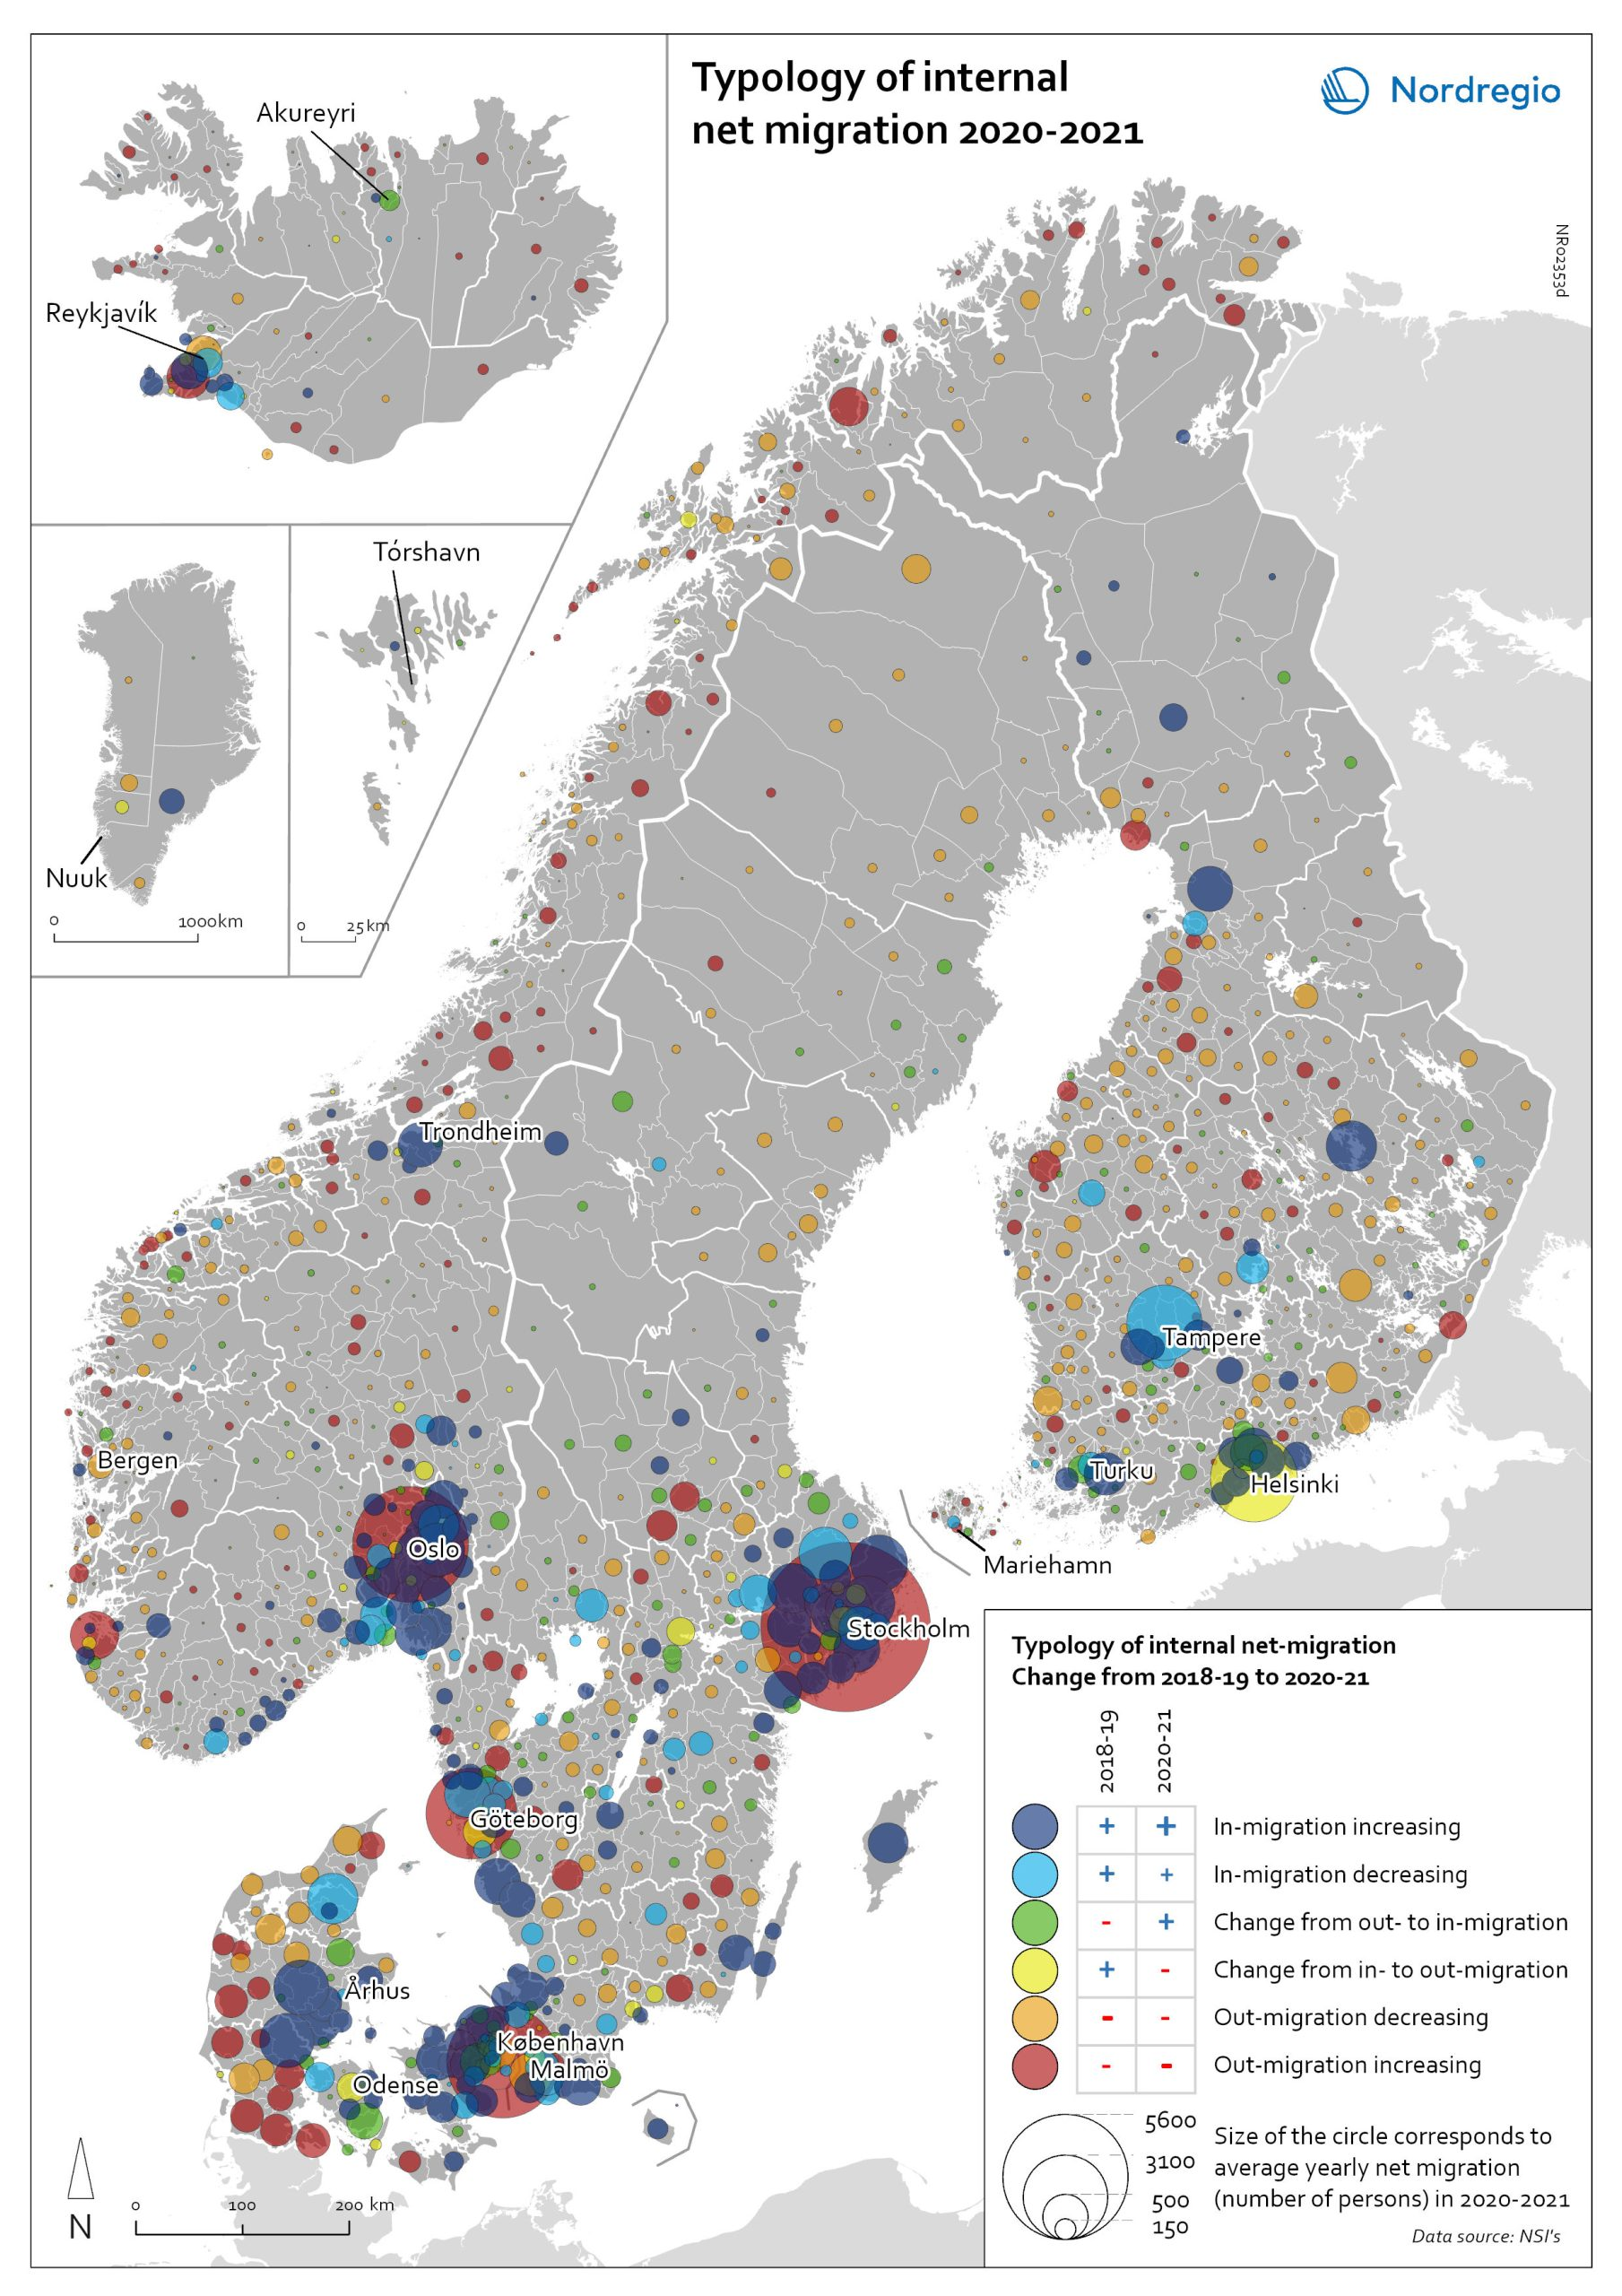

In [28]:
# Reference work for internal migration classification:
img = Image(filename="data/nordregio_reference_classification.jpg", width=500)
display(img)

In [29]:
# Define a function to classify migration trends based on net migration in 2020-2022 and 2018-2020.
def classify_migration(row):
    if row['net_2020_2022'] > 0 and row['net_2018_2020'] > 0:  # Check if net migration was positive in both periods
        if row['net_2020_2022'] > row['net_2018_2020']:  # Check if net migration increased from 2018-2020 to 2020-2022
            return 'Dark Blue Class'  # If so, classify as "Dark Blue Class" (accelerating in-migration trend)
        else:
            return 'Light Blue Class'  # Otherwise, classify as "Light Blue Class" (slowing in-migration trend)
    elif row['net_2020_2022'] > 0 and row['net_2018_2020'] <= 0:  # Check if net migration turned from non-positive to positive
        return 'Green Class'  # If so, classify as "Green Class" (new in-migration trend)
    elif row['net_2020_2022'] < 0 and row['net_2018_2020'] >= 0:  # Check if net migration turned from non-negative to negative
        return 'Yellow Class'  # If so, classify as "Yellow Class" (new out-migration trend)
    elif row['net_2020_2022'] < 0 and row['net_2018_2020'] < 0:  # Check if net migration was negative in both periods
        if row['net_2020_2022'] > row['net_2018_2020']:  # Check if net migration became less negative from 2018-2020 to 2020-2022
            return 'Orange Class'  # If so, classify as "Orange Class" (slowing out-migration trend)
        else:
            return 'Red Class'  # Otherwise, classify as "Red Class" (accelerating out-migration trend)
    else:
        return 'No Class'  # If none of the conditions above are met, do not classify
    
#Applying the classification in the data:
in_out_migration_sweden_class['Class'] = in_out_migration_sweden_class.apply(classify_migration, axis=1)

# create a dictionary mapping each class to a number
class_number_mapping = {
    'Dark Blue Class': 1,
    'Light Blue Class': 2,
    'Green Class': 3,
    'Yellow Class': 4,
    'Orange Class': 5,
    'Red Class': 6,
    'No Class': 0
}

# add a new column 'Class_Number' to the dataframe that maps the 'Class' column to its corresponding number
in_out_migration_sweden_class['Class_Number'] = in_out_migration_sweden_class['Class'].map(class_number_mapping)

display(in_out_migration_sweden_class)

Year,MUN,Age_Group,2018,2020,2022,net_2018_2020,net_2020_2022,Class,Class_Number
0,Bjuv,Elderly,-21,-16,-19,5,-3,Yellow Class,4
1,Bjuv,Working age,-106,-18,91,88,109,Dark Blue Class,1
2,Bjuv,Youth,23,6,62,-17,56,Green Class,3
3,Bromölla,Elderly,6,-14,12,-20,26,Green Class,3
4,Bromölla,Working age,48,-67,-25,-115,42,Green Class,3
...,...,...,...,...,...,...,...,...,...
112,Örkelljunga,Working age,63,105,-28,42,-133,Yellow Class,4
113,Örkelljunga,Youth,33,58,16,25,-42,Yellow Class,4
114,Östra Göinge,Elderly,-22,-12,-22,10,-10,Yellow Class,4
115,Östra Göinge,Working age,-154,-90,-229,64,-139,Yellow Class,4


In [30]:
# Visualizing municipalities with classification: No Class
no_class_df = in_out_migration_sweden_class[in_out_migration_sweden_class['Class'] == 'No Class']
#display(no_class_df)

In [31]:
# # Group by 'Class' and calculate min and max for 'net_2018_2020' and 'net_2020_2022'
# class_summary = in_out_migration_sweden_class.groupby('Class').agg(
#     min_net_2018_2020=('net_2018_2020', 'min'),
#     max_net_2018_2020=('net_2018_2020', 'max'),
#     min_net_2020_2022=('net_2020_2022', 'min'),
#     max_net_2020_2022=('net_2020_2022', 'max')
# )

# display(class_summary)

In [32]:
# # Double Checking procedure: verifying the values of internal migration for specific municipalities.
# selected_municipality = 'Malmö'
# municipality_data = in_out_migration_sweden_class[in_out_migration_sweden_class['MUN'] == selected_municipality]

# display(municipality_data)

In [33]:
# Merging classified data to the shapefile of the GDR:
sweden_class_gdf = sweden_gdf.merge(in_out_migration_sweden_class, left_on='MUN_NORDIC', right_on='MUN', how='left')

# Convert column names to string
sweden_class_gdf.columns = sweden_class_gdf.columns.astype(str)

# Shorten column names if they are longer than 10 characters
sweden_class_gdf.columns = [col[:10] if len(col) > 10 else col for col in sweden_class_gdf.columns]

# Ensure the 'Class' column is of type string
sweden_class_gdf['Class'] = sweden_class_gdf['Class'].astype(str)

# Create new directory if it doesn't exist:
if not os.path.exists('data/classification'):
    os.makedirs('data/classification')

# Saving one shapefile with all the classes:
sweden_class_gdf.to_file("data/classification/SE_classification.shp")

# Loop over each group (grouped by 'Age Group') and save to a separate Shapefile:
for name, group in sweden_class_gdf.groupby('Age_Group'):
    # Define the filename for the Shapefile
    filename = f"data/classification/SE_classification_{name}.shp"
    group.to_file(filename)

# # Display the merged GeoDataFrame
# display(sweden_class_gdf)

In [34]:
# Calculate net migration for each year: NO AGE GROUPS CONSIDERED, only the net migration per year:
in_out_migration_sweden['NET_MIG'] = in_out_migration_sweden['INMIG'] - in_out_migration_sweden['OUTMIG']

# create pivot table
in_out_migration_sweden_class_year = in_out_migration_sweden.pivot_table(index='MUN', columns='Year', values='NET_MIG', aggfunc='sum')

# calculate net migration for 2018-2020 and 2020-2022
in_out_migration_sweden_class_year['net_2018_2020'] = (in_out_migration_sweden_class_year[2020] - in_out_migration_sweden_class_year[2018])
in_out_migration_sweden_class_year['net_2020_2022'] = (in_out_migration_sweden_class_year[2022] - in_out_migration_sweden_class_year[2020])

# reset index to make Municipality as a column again
in_out_migration_sweden_class_year.reset_index(inplace=True)

#display(in_out_migration_sweden_class_year)

In [35]:
#Classifying the net migration change per year (NO AGE GROUP CONSIDERED)
in_out_migration_sweden_class_year['Class'] = in_out_migration_sweden_class_year.apply(classify_migration, axis=1)
#display(in_out_migration_sweden_class_year)

In [36]:
# Merging in and out migration change classification per year in shapefile (NO AGE GROUP CONSIDERED):
merged_gdf_all = sweden_gdf.merge(in_out_migration_sweden_class_year, left_on='MUN_NORDIC', right_on='MUN', how='left')

# Convert column names to string
merged_gdf_all.columns = merged_gdf_all.columns.astype(str)

# Shorten column names if they are longer than 10 characters
merged_gdf_all.columns = [col[:10] if len(col) > 10 else col for col in merged_gdf_all.columns]

# Ensure the 'Class' column is of type string
merged_gdf_all['Class'] = merged_gdf_all['Class'].astype(str)

# Now try to save as a shapefile
merged_gdf_all.to_file("data/classification/classification_change_peryear_sweden.shp")

## Cleaning, Verifying, and Standardizing Data for Denmark

The Danish data was obtained manually from the StatBank Denmark website (https://www.statbank.dk/statbank5a/default.asp?w=1920). Unlike the Swedish database, an automated JSON query was not available. 

The specific dataset used for total population data was the "BY2: Population 1. January by municipality, size of the city, age and sex" table, which provides information on population within Denmark.

The specific variables selected from this dataset were:

- Municipality. This variable was used to select the municipalities.
- Age: Broken down into 5-year age groups.
- Sex: Data is split by Men and Women.
- Year: The years selected for this analysis were 2018, 2020, and 2022.

The specific dataset used for internal migration data was the "FLY66: Internal migration between municipalities" table, which provides information on migration patterns within Denmark.

The specific variables selected from this dataset were:

- In Migration and Out Migration. These represent the flow of people moving into and out of the municipalities.
- Age: Broken down into 5-year age groups.
- Sex: Data is split by Men and Women.
- Year: The years selected for this analysis were 2018, 2020, and 2022.

The selection of municipalities for the study was guided by the list present in 'df_municipalities'.

I manually downloaded and cleaned the data for this analysis, but I'm interested in automating this process in the future. If you have suggestions or resources on how to automate data collection from StatBank Denmark or similar sources, your input would be welcome.

In [37]:
# Replace "Copenhagen" with "København" in 'in migration' column
df_denmark_total_population['municipality'] = df_denmark_total_population['municipality'].replace("Copenhagen", "København")

# Adding the columns from the df_municipalities DataFrame to the df_denmark_inmigration DataFrame, aligning the data based on the 'Municipality' and 'MUN_NORDIC' values.
df_denmark_total_population = pd.merge(df_denmark_total_population, df_municipalities, left_on='municipality', right_on='MUN_NORDIC', how='left')

# Adding the columns from the df_mun_sweden DataFrame to the df_sweden DataFrame, aligning the data based on the 'Municipality' and 'MUN_NORDIC' values.
if 'MUN_NORDIC' not in df_denmark_total_population.columns:
    df_denmark_total_population = pd.merge(df_denmark_total_population, df_municipalities, left_on='municipality', right_on='MUN_NORDIC', how='left')
# Deleting NUTS3_2016 empty column.
if 'NUTS3_2016' in df_denmark_total_population.columns:
    df_denmark_total_population = df_denmark_total_population.drop(columns=['NUTS3_2016'])

# Visualizing:
#df_denmark_total_population

In [38]:
# Save the altered dataframes to new CSV. and txt. files
df_denmark_total_population.to_csv('data/df_denmark_total_population.csv', index=False)
df_denmark_total_population.to_csv('data/df_denmark_total_population.txt', index=False, sep='\t')

### Organizing Internal Migration Data for Denmark

In [39]:
# Cleaning and standardizing the data:
# Remove "To " from 'in migration' column
df_denmark_inmigration['in migration'] = df_denmark_inmigration['in migration'].str.replace("To ", "")

# Remove "From " from 'out migration' column
df_denmark_outmigration['out migration'] = df_denmark_outmigration['out migration'].str.replace("From ", "")

# Replace "Copenhagen" with "København" in 'in migration' column
df_denmark_inmigration['in migration'] = df_denmark_inmigration['in migration'].replace("Copenhagen", "København")

# Replace "Copenhagen" with "København" in 'out migration' column
df_denmark_outmigration['out migration'] = df_denmark_outmigration['out migration'].replace("Copenhagen", "København")

In [40]:
# IN MIGRATION
# Adding the columns from the df_municipalities DataFrame to the df_denmark_inmigration DataFrame, aligning the data based on the 'Municipality' and 'MUN_NORDIC' values.
df_denmark_inmigration = pd.merge(df_denmark_inmigration, df_municipalities, left_on='in migration', right_on='MUN_NORDIC', how='left')

# Visualizing:
#df_denmark_inmigration

In [41]:
# #To visualize any of the verifications, uncomment the respective line below:
# #Checking the number of municipalities after merging:
# num_municipalities = df_denmark_inmigration['in migration'].nunique()
# print(f'There are {num_municipalities} unique municipalities in the "in migration" column.')

In [42]:
# OUT MIGRATION
# Adding the columns from the df_municipalities DataFrame to the df_denmark_outmigration DataFrame, aligning the data based on the 'Municipality' and 'MUN_NORDIC' values.
df_denmark_outmigration = pd.merge(df_denmark_outmigration, df_municipalities, left_on='out migration', right_on='MUN_NORDIC', how='left')

# Visualizing:
#df_denmark_outmigration

In [43]:
# # To visualize any of the verifications, uncomment the respective line below:
# # Checking the number of municipalities after merging:
# num_municipalities = df_denmark_outmigration['out migration'].nunique()
# print(f'There are {num_municipalities} unique municipalities in the "out migration" column.')

In [44]:
# Drop 'NUTS3_2016' column
df_denmark_inmigration = df_denmark_inmigration.drop(columns=['NUTS3_2016'])
df_denmark_outmigration = df_denmark_outmigration.drop(columns=['NUTS3_2016'])

In [45]:
# # To visualize any of the verifications, uncomment the respective line below:
# # Checking missing values after merging:
# # In-migration Dataframe:
# missing_values_inmigration = df_denmark_inmigration.isnull().sum().sum()
# print(f'There are {missing_values_inmigration} missing values in the "in migration" dataset.')
# # Out-migration Dataframe:
# missing_values_outmigration = df_denmark_outmigration.isnull().sum().sum()
# print(f'There are {missing_values_outmigration} missing values in the "out migration" dataset.')

In [46]:
# Save the altered dataframes to new CSV. and txt. files
df_denmark_inmigration.to_csv('data/denmark_inmigration.csv', index=False)
df_denmark_inmigration.to_csv('data/denmark_inmigration.txt', index=False, sep='\t')
df_denmark_outmigration.to_csv('data/denmark_outmigration.csv', index=False)
df_denmark_outmigration.to_csv('data/denmark_outmigration.txt', index=False, sep='\t')

### Calculating the Migration Rates and Percentages for Denmark

In [47]:
# Classifying age groups into Young, Working Age and Elderly:
# Define a function to map age ranges to new categories:
def map_age_group(age_range):
    if age_range in ['0-4 years', '5-9 years', '10-14 years']:
        return 'Youth'
    elif age_range in ['15-19 years', '20-24 years', '25-29 years', '30-34 years', '35-39 years', '40-44 years', '45-49 years', '50-54 years', '55-59 years', '60-64 years']:
        return 'Working age'
    else:
        return 'Elderly'

# List of dataframes to loop over:
dfs = [df_denmark_inmigration, df_denmark_outmigration, df_denmark_total_population]

# Apply the function to create new 'Age Group' columns in each DataFrame:
for df in dfs:
    df['Age_Group'] = df['age'].apply(map_age_group)

#### Total Population Data

In [48]:
# Assume that 'df' is your original dataframe
denmark_total_pop = df_denmark_total_population.melt(id_vars=['sex', 'age', 'municipality', 'COD_MUN', 'MUN_NORDIC', 'COD_REG', 'REG_NORDIC', 'CNTR', 'DGURBA', 'Age_Group'], 
                    value_vars=['2018', '2020', '2022'], 
                    var_name='Year', 
                    value_name='Total_Population')

# If you want to rename the column names
denmark_total_pop.rename(columns={'municipality':'MUN', 'Total_Population': 'TOTALPOP'}, inplace=True)

# Now the 'df_melted' dataframe should have the format you want
display(denmark_total_pop)

,sex,age,MUN,COD_MUN,MUN_NORDIC,COD_REG,REG_NORDIC,CNTR,DGURBA,Age_Group,Year,TOTALPOP
0,Men,0-4 years,København,DK101,København,DK01,Hovedstaden,DK,Urban,Youth,2018,20184
1,Men,0-4 years,Frederiksberg,DK147,Frederiksberg,DK01,Hovedstaden,DK,Urban,Youth,2018,3268
2,Men,0-4 years,Dragør,DK155,Dragør,DK01,Hovedstaden,DK,Intermediate,Youth,2018,376
3,Men,0-4 years,Tårnby,DK185,Tårnby,DK01,Hovedstaden,DK,Urban,Youth,2018,1308
4,Men,0-4 years,Albertslund,DK165,Albertslund,DK01,Hovedstaden,DK,Urban,Youth,2018,775
...,...,...,...,...,...,...,...,...,...,...,...,...
6481,Women,110 years +,Ringsted,DK329,Ringsted,DK02,Sjælland,DK,Intermediate,Elderly,2022,0
6482,Women,110 years +,Slagelse,DK330,Slagelse,DK02,Sjælland,DK,Intermediate,Elderly,2022,0
6483,Women,110 years +,Sorø,DK340,Sorø,DK02,Sjælland,DK,Rural,Elderly,2022,0
6484,Women,110 years +,Stevns,DK336,Stevns,DK02,Sjælland,DK,Rural,Elderly,2022,0


In [49]:
# Group the data and sum up the values in the specific columns
denmark_total_pop_stats = denmark_total_pop.groupby([ 'Year', 'MUN', 'DGURBA']).agg({ 
    'TOTALPOP': 'sum'
}).reset_index()

denmark_total_pop_stats.to_csv('data/denmark_total_pop_stats.csv', index=False)
#denmark_total_pop_stats

#### In-migration Data

In [50]:
# Working with In migration data for Denmark:
denmark_in_migration = df_denmark_inmigration.melt(id_vars=['sex', 'age', 'in migration', 'COD_MUN', 'MUN_NORDIC', 'COD_REG', 'REG_NORDIC', 'CNTR', 'DGURBA', 'Age_Group'], 
                    value_vars=['2018', '2020', '2022'], 
                    var_name='Year', 
                    value_name='Internal_Inmigrations')

# If you want to rename the column names
denmark_in_migration.rename(columns={'in migration':'MUN', 'Internal_Inmigrations':'INMIG'}, inplace=True)

# Print table
#display(denmark_in_migration)

In [51]:
# Group the data and sum up the values in the specific columns:
denmark_in_migration_stats = denmark_in_migration.groupby(['Age_Group', 'Year', 'MUN', 'DGURBA']).agg({
    'INMIG': 'sum'
}).reset_index()

#Save the data into csv file in your folder:
denmark_in_migration_stats.to_csv('data/denmark_in_migration_stats.csv', index=False)

# #Visualize the table:
# denmark_in_migration_stats

In [52]:
# Create a mapping from ('MUN', 'Year') to 'TOTALPOP':
mapping = denmark_total_pop_stats.set_index(['MUN', 'Year'])['TOTALPOP']

# Create a new column in 'denmark_in_migration_stats' by mapping the ('MUN', 'Year') to 'Total_Population' using the created mapping
denmark_in_migration_stats['TOTALPOP'] = denmark_in_migration_stats.set_index(['MUN', 'Year']).index.map(mapping)

# Reset the index of 'df_melted_sats'
denmark_in_migration_stats.reset_index(inplace=True)

# #Print table:
# denmark_in_migration_stats

In [53]:
# Calculate the in-migration and outmigration percentages:
denmark_in_migration_stats['INMIG%'] = (denmark_in_migration_stats['INMIG'] / denmark_in_migration_stats['TOTALPOP']) * 100

# Calculate the inmigration rate per 1000 inhabitants
denmark_in_migration_stats['INMG_INHB'] = (denmark_in_migration_stats['INMIG'] / denmark_in_migration_stats['TOTALPOP']) * 1000

# #Print table:
# denmark_in_migration_stats

#### Shapefile Join Information/Statistics

In [54]:
# Define the years and age groups
years = [2018, 2020, 2022]
age_groups = ['Youth', 'Working age', 'Elderly']
data = 'inmigration'

# Define the columns and their types
cols_to_convert = {
    'Year': int,
    'INMIG': int,
    'TOTALPOP': int,
    'INMIG%': int,
    'INMG_INHB': int
}

# Convert the types of the specified columns in 'df_melted_sats'
for col, col_type in cols_to_convert.items():
    denmark_in_migration_stats[col] = denmark_in_migration_stats[col].astype(col_type)

# Merge 'df_melted_sats' with 'denmark_gdf'
merged_gdf = denmark_gdf.merge(denmark_in_migration_stats, left_on='MUN_NORDIC', right_on='MUN', how='inner')

# Create new directory if it doesn't exist:
if not os.path.exists('data/per_1000_inhab_DEN/inmig'):
    os.makedirs('data/per_1000_inhab_DEN/inmig')

# For each combination of age group and year, create a separate shapefile:
for year in years:
    for age_group in age_groups:
        # Subset the data
        subset_gdf = merged_gdf[(merged_gdf['Year'] == year) & (merged_gdf['Age_Group'] == age_group)]
        
        # Save the subset to a shapefile
        subset_gdf.to_file(f"data/per_1000_inhab_DEN/inmig/DEN_perhab_{age_group.replace(' ', '_')}_{year}_{data}.shp")

#### Out-migration Data

In [55]:
# Working with Out migration data for Denmark:
denmark_out_migration = df_denmark_outmigration.melt(id_vars=['sex', 'age', 'out migration', 'COD_MUN', 'MUN_NORDIC', 'COD_REG', 'REG_NORDIC', 'CNTR', 'DGURBA', 'Age_Group'], 
                    value_vars=['2018', '2020', '2022'], 
                    var_name='Year', 
                    value_name='Outmig_int')

# If you want to rename the column names:
denmark_out_migration.rename(columns={'out migration':'MUN', 'Outmig_int':'OUTMIG'}, inplace=True)

# # Print table
# display(denmark_out_migration)

In [56]:
# Group the data and sum up the values in the specific columns:
denmark_out_migration_stats = denmark_out_migration.groupby(['Age_Group', 'Year', 'MUN', 'DGURBA']).agg({
    'OUTMIG': 'sum'
}).reset_index()

denmark_out_migration_stats.to_csv('data/denmark_out_migration_stats.csv', index=False)

# # Print table
# denmark_out_migration_stats

In [57]:
# Create a mapping from ('MUN', 'Year') to 'TOTALPOP'
mapping = denmark_total_pop_stats.set_index(['MUN', 'Year'])['TOTALPOP']

# Create a new column in 'denmark_out_migration_stats' by mapping the ('MUN', 'Year') to 'TOTALPOP' using the created mapping
denmark_out_migration_stats['TOTALPOP'] = denmark_out_migration_stats.set_index(['MUN', 'Year']).index.map(mapping)

# Reset the index of 'denmark_out_migration_stats'
denmark_out_migration_stats.reset_index(inplace=True)

# Print table
#denmark_out_migration_stats

In [58]:
# Calculate the inmigration and outmigration percentages
denmark_out_migration_stats['OUTMIG%'] = (denmark_out_migration_stats['OUTMIG'] / denmark_out_migration_stats['TOTALPOP']) * 100

# Calculate the inmigration rate per 1000 inhabitants
denmark_out_migration_stats['OUTMG_INHB'] = (denmark_out_migration_stats['OUTMIG'] / denmark_out_migration_stats['TOTALPOP']) * 1000

# # Print table
# denmark_out_migration_stats

In [59]:
# Define the years and age groups
years = [2018, 2020, 2022]
age_groups = ['Youth', 'Working age', 'Elderly']
data = 'outmigration'

# Define the columns and their types
cols_to_convert = {
    'Year': int,
    'OUTMIG': int,
    'TOTALPOP': int,
    'OUTMIG%': int,
    'OUTMG_INHB': int
}

# Convert the types of the specified columns in 'df_melted_sats'
for col, col_type in cols_to_convert.items():
    denmark_out_migration_stats[col] = denmark_out_migration_stats[col].astype(col_type)

# Merge 'df_melted_sats' with 'denmark_gdf'
merged_gdf = denmark_gdf.merge(denmark_out_migration_stats, left_on='MUN_NORDIC', right_on='MUN', how='inner')

# Create new directory if it doesn't exist:
if not os.path.exists('data//per_1000_inhab_DEN/outmig'):
    os.makedirs('data//per_1000_inhab_DEN/outmig')

# For each combination of age group and year, create a separate shapefile
for year in years:
    for age_group in age_groups:
        # Subset the data
        subset_gdf = merged_gdf[(merged_gdf['Year'] == year) & (merged_gdf['Age_Group'] == age_group)]
        
        # Save the subset to a shapefile
        subset_gdf.to_file(f"data//per_1000_inhab_DEN/outmig/DEN_perhab_{age_group.replace(' ', '_')}_{year}_{data}.shp")

## Merging In and Out data for Denmark

In [60]:
# Merging In and Out migration Data
in_out_migration_denmark_sats = pd.merge(denmark_in_migration_stats, denmark_out_migration_stats, on=['MUN', 'Year', 'Age_Group', 'DGURBA'], how='inner')

# Check if 'Total_Population_x' and 'Total_Population_y' are identical
print(all(in_out_migration_denmark_sats['TOTALPOP_x'] == in_out_migration_denmark_sats['TOTALPOP_y']))

# If the above line prints True, then you can proceed with this:
in_out_migration_denmark_sats['TOTALPOP'] = in_out_migration_denmark_sats['TOTALPOP_x']
in_out_migration_denmark_sats = in_out_migration_denmark_sats[['Age_Group', 'Year', 'MUN', 'DGURBA', 'INMIG', 'OUTMIG', 'TOTALPOP']]

# Display the final dataframe
in_out_migration_denmark_sats

True


,Age_Group,Year,MUN,DGURBA,INMIG,OUTMIG,TOTALPOP
0,Elderly,2018,Albertslund,Urban,38,72,27743
1,Elderly,2018,Allerød,Intermediate,67,66,25235
2,Elderly,2018,Ballerup,Intermediate,110,125,48295
3,Elderly,2018,Bornholm,Rural,109,88,39632
4,Elderly,2018,Brøndby,Urban,57,107,35538
...,...,...,...,...,...,...,...
418,Youth,2022,Sorø,Rural,376,220,30018
419,Youth,2022,Stevns,Rural,249,188,23473
420,Youth,2022,Tårnby,Urban,411,277,42723
421,Youth,2022,Vallensbæk,Urban,296,249,16488


In [61]:
# Make a copy of the DataFrame before creating the new column:
in_out_migration_denmark_sats = in_out_migration_denmark_sats.copy()

# calculate net migration for each year
in_out_migration_denmark_sats['NET_MIG'] = in_out_migration_denmark_sats['INMIG'] - in_out_migration_denmark_sats['OUTMIG']

# create pivot table
in_out_migration_denmark_class = in_out_migration_denmark_sats.pivot_table(index=['MUN', 'Age_Group'], columns='Year', values='NET_MIG')

# calculate net migration for 2018-2020 and 2020-2022
in_out_migration_denmark_class['net_2018_2020'] = in_out_migration_denmark_class[2020] - in_out_migration_denmark_class[2018]
in_out_migration_denmark_class['net_2020_2022'] = in_out_migration_denmark_class[2022] - in_out_migration_denmark_class[2020]

# reset index to make Municipality and Age Group as columns again
in_out_migration_denmark_class.reset_index(inplace=True)

#display(in_out_migration_denmark_class)

### Classifying Denmark data:

In [62]:
# Define a function to classify migration trends based on net migration in 2020-2022 and 2018-2020.
def classify_migration(row):
    if row['net_2020_2022'] > 0 and row['net_2018_2020'] > 0:  # Check if net migration was positive in both periods
        if row['net_2020_2022'] > row['net_2018_2020']:  # Check if net migration increased from 2018-2020 to 2020-2022
            return 'Dark Blue Class'  # If so, classify as "Dark Blue Class" (accelerating in-migration trend)
        else:
            return 'Light Blue Class'  # Otherwise, classify as "Light Blue Class" (slowing in-migration trend)
    elif row['net_2020_2022'] > 0 and row['net_2018_2020'] <= 0:  # Check if net migration turned from non-positive to positive
        return 'Green Class'  # If so, classify as "Green Class" (new in-migration trend)
    elif row['net_2020_2022'] < 0 and row['net_2018_2020'] >= 0:  # Check if net migration turned from non-negative to negative
        return 'Yellow Class'  # If so, classify as "Yellow Class" (new out-migration trend)
    elif row['net_2020_2022'] < 0 and row['net_2018_2020'] < 0:  # Check if net migration was negative in both periods
        if row['net_2020_2022'] > row['net_2018_2020']:  # Check if net migration became less negative from 2018-2020 to 2020-2022
            return 'Orange Class'  # If so, classify as "Orange Class" (slowing out-migration trend)
        else:
            return 'Red Class'  # Otherwise, classify as "Red Class" (accelerating out-migration trend)
    else:
        return 'No Class'  # If none of the conditions above are met, do not classify

in_out_migration_denmark_class['Class'] = in_out_migration_denmark_class.apply(classify_migration, axis=1)

# Create a dictionary mapping each class to a number
class_number_mapping = {
    'Dark Blue Class': 1,
    'Light Blue Class': 2,
    'Green Class': 3,
    'Yellow Class': 4,
    'Orange Class': 5,
    'Red Class': 6,
    'No Class': 0
}

# create a new column 'Class_Number' by mapping the 'Class' column using the dictionary
in_out_migration_denmark_class['Class_Number'] = in_out_migration_denmark_class['Class'].map(class_number_mapping)

display(in_out_migration_denmark_class)

Year,MUN,Age_Group,2018,2020,2022,net_2018_2020,net_2020_2022,Class,Class_Number
0,Albertslund,Elderly,-34,-25,-29,9,-4,Yellow Class,4
1,Albertslund,Working age,-79,-384,-310,-305,74,Green Class,3
2,Albertslund,Youth,44,-12,-10,-56,2,Green Class,3
3,Allerød,Elderly,1,25,-5,24,-30,Yellow Class,4
4,Allerød,Working age,91,-54,-111,-145,-57,Orange Class,5
...,...,...,...,...,...,...,...,...,...
136,Vallensbæk,Working age,71,-231,161,-302,392,Green Class,3
137,Vallensbæk,Youth,32,-40,47,-72,87,Green Class,3
138,Vordingborg,Elderly,73,24,7,-49,-17,Orange Class,5
139,Vordingborg,Working age,-131,-140,-96,-9,44,Green Class,3


In [63]:
# # Double Checking procedure: verifying the values of internal migration for specific municipalities.
# selected_municipality = 'Allerød'
# municipality_data = in_out_migration_denmark_class[in_out_migration_denmark_class['MUN'] == selected_municipality]

# display(in_out_migration_denmark_class)

In [64]:
# Merging in and out migration change classification per year in shapefile (NO AGE GROUP CONSIDERED):
denmark_class_gdf = denmark_gdf.merge(in_out_migration_denmark_class, left_on='MUN_NORDIC', right_on='MUN', how='left')

# Convert column names to string
denmark_class_gdf.columns = denmark_class_gdf.columns.astype(str)

# Shorten column names if they are longer than 10 characters
denmark_class_gdf.columns = [col[:10] if len(col) > 10 else col for col in denmark_class_gdf.columns]

# Ensure the 'Class' column is of type string
denmark_class_gdf['Class'] = denmark_class_gdf['Class'].astype(str)

#Save as a shapefile (NO AGE GROUP CONSIDERED):
denmark_class_gdf.to_file("data/classification/DEN_classification.shp")

# Loop over each group (grouped by 'Age Group') and save to a separate Shapefile ***(AGE GROUP CONSIDERED)***:
for name, group in denmark_class_gdf.groupby('Age_Group'):
    # Define the filename for the Shapefile
    filename = f"data/classification/DEN_classification_{name}.shp"
    group.to_file(filename)

# # Display the merged GeoDataFrame
# display(denmark_class_gdf)

In [65]:
# # Verifications:
# # Display the first few rows of the in_out_migration_denmark_class dataframe
# print("in_out_migration_denmark_class dataframe:")
# print(in_out_migration_denmark_class.head())

# # Display the columns of the in_out_migration_denmark_class dataframe
# print("\nColumns in in_out_migration_denmark_class dataframe:")
# print(in_out_migration_denmark_class.columns)

# # Display the first few rows of the in_out_migration_denmark_class dataframe
# print("\nin_out_migration_denmark_class dataframe:")
# print(in_out_migration_denmark_class.head())

# # Display the columns of the in_out_migration_denmark_class dataframe
# print("\nColumns in in_out_migration_denmark_class dataframe:")
# print(in_out_migration_denmark_class.columns)

## Merging Sweden and Denmark Internal In and Out migration Data:

In [66]:
# Create a copy of the dataframes and add a 'Country' column
in_out_migration_denmark_sats = in_out_migration_denmark_sats.copy()
in_out_migration_denmark_sats['Country'] = 'Denmark'

in_out_migration_sweden = in_out_migration_sweden.copy()
in_out_migration_sweden['Country'] = 'Sweden'

# Select only the common columns you are interested in
common_cols = ['Age_Group', 'Year', 'MUN', 'DGURBA', 'INMIG', 'OUTMIG', 'TOTALPOP', 'Country']

in_out_migration_denmark_sats = in_out_migration_denmark_sats[common_cols]
in_out_migration_sweden = in_out_migration_sweden[common_cols]

# Merge the dataframes
in_out_migration_greater_region = pd.concat([in_out_migration_denmark_sats, in_out_migration_sweden])

# Check the merged dataframe
print(in_out_migration_greater_region.head())

  Age_Group  Year          MUN        DGURBA  INMIG  OUTMIG  TOTALPOP  Country
0   Elderly  2018  Albertslund         Urban     38      72     27743  Denmark
1   Elderly  2018      Allerød  Intermediate     67      66     25235  Denmark
2   Elderly  2018     Ballerup  Intermediate    110     125     48295  Denmark
3   Elderly  2018     Bornholm         Rural    109      88     39632  Denmark
4   Elderly  2018      Brøndby         Urban     57     107     35538  Denmark


#### Annual Average Internal Net Migration

In [67]:
# Group the data and sum up the values in the specific columns
net_annual_percent_GCR = in_out_migration_greater_region.groupby(['Year','MUN']).agg({ #
    'INMIG': 'sum',
    'OUTMIG': 'sum',
    'TOTALPOP': 'sum'
}).reset_index()

# # Display the columns of the net_annual_percent_GCR dataframe
# print("\nColumns in net_annual_percent_GCR dataframe:")
# print(net_annual_percent_GCR.columns)

In [68]:
# Calculate annual net migration
net_annual_percent_GCR['NET_MIG'] = net_annual_percent_GCR['INMIG'] - net_annual_percent_GCR['OUTMIG']

# Calculate the annual average net migration as a percentage of the total population
net_annual_percent_GCR['NET_MIG%'] = (net_annual_percent_GCR['NET_MIG'] / net_annual_percent_GCR['TOTALPOP']) * 100

In [69]:
# Filter rows for years 2020 and 2022
years = [2020, 2022]
filtered_df = net_annual_percent_GCR[net_annual_percent_GCR['Year'].isin(years)]

# Group by municipality and calculate average yearly net migration
result_df = filtered_df.groupby('MUN')['NET_MIG'].mean().reset_index()

# Rename column
result_df.rename(columns = {'NET_MIG':'YANM_20_22'}, inplace = True)

# Take the absolute value of YANM_20_22
result_df['YANM_20_22'] = result_df['YANM_20_22'].abs()

# Ensure YANM_20_22 does not exist in net_annual_percent_df before merge
if 'YANM_20_22' in net_annual_percent_GCR.columns:
    net_annual_percent_GCR.drop('YANM_20_22', axis=1, inplace=True)

# Merge the result back to the original dataframe
net_annual_percent_GCR = pd.merge(net_annual_percent_GCR, result_df, on='MUN', how='left')

#Print table:
net_annual_percent_GCR

,Year,MUN,INMIG,OUTMIG,TOTALPOP,NET_MIG,NET_MIG%,YANM_20_22
0,2018,Albertslund,2116,2185,83229,-69,-0.082904,385.0
1,2018,Allerød,1777,1400,75705,377,0.497986,78.5
2,2018,Ballerup,2877,2831,144885,46,0.031749,468.5
3,2018,Bjuv,1158,1262,46503,-104,-0.223641,53.0
4,2018,Bornholm,1306,1148,118896,158,0.132889,87.0
...,...,...,...,...,...,...,...,...
253,2022,Ystad,1665,1425,95142,240,0.252255,358.5
254,2022,Ängelholm,2413,1900,132804,513,0.386284,445.5
255,2022,Åstorp,1320,1386,49023,-66,-0.134631,23.5
256,2022,Örkelljunga,661,693,31365,-32,-0.102025,73.0


In [70]:
# Merge the data with the shapefile of the GCR
net_annual_percent_GCR = gchr_gdf.merge(net_annual_percent_GCR, left_on='MUN_NORDIC', right_on='MUN', how='left')

# Convert column names to string
net_annual_percent_GCR.columns = net_annual_percent_GCR.columns.astype(str)

# Shorten column names if they are longer than 10 characters
net_annual_percent_GCR.columns = [col[:10] if len(col) > 10 else col for col in net_annual_percent_GCR.columns]

# # Ensure the 'Class' column is of type string
# net_annual_percent_GCR['Class'] = net_annual_percent_GCR['Class'].astype(str)

# Now try to save as a shapefile
net_annual_percent_GCR.to_file("data/classification/net_annual_percent_GCR.shp")

# List of years in your data
years = [2018, 2020, 2022]

# Loop through each year
for year in years:
    # Filter data for the specific year
    year_data = net_annual_percent_GCR[net_annual_percent_GCR['Year'] == year]
    
    # Save the filtered data as a shapefile
    year_data.to_file(f"data/classification/net_annual_percent_GCR_{year}.shp")

## Analysis

### Graphs and tables

#### Absolute Numbers:

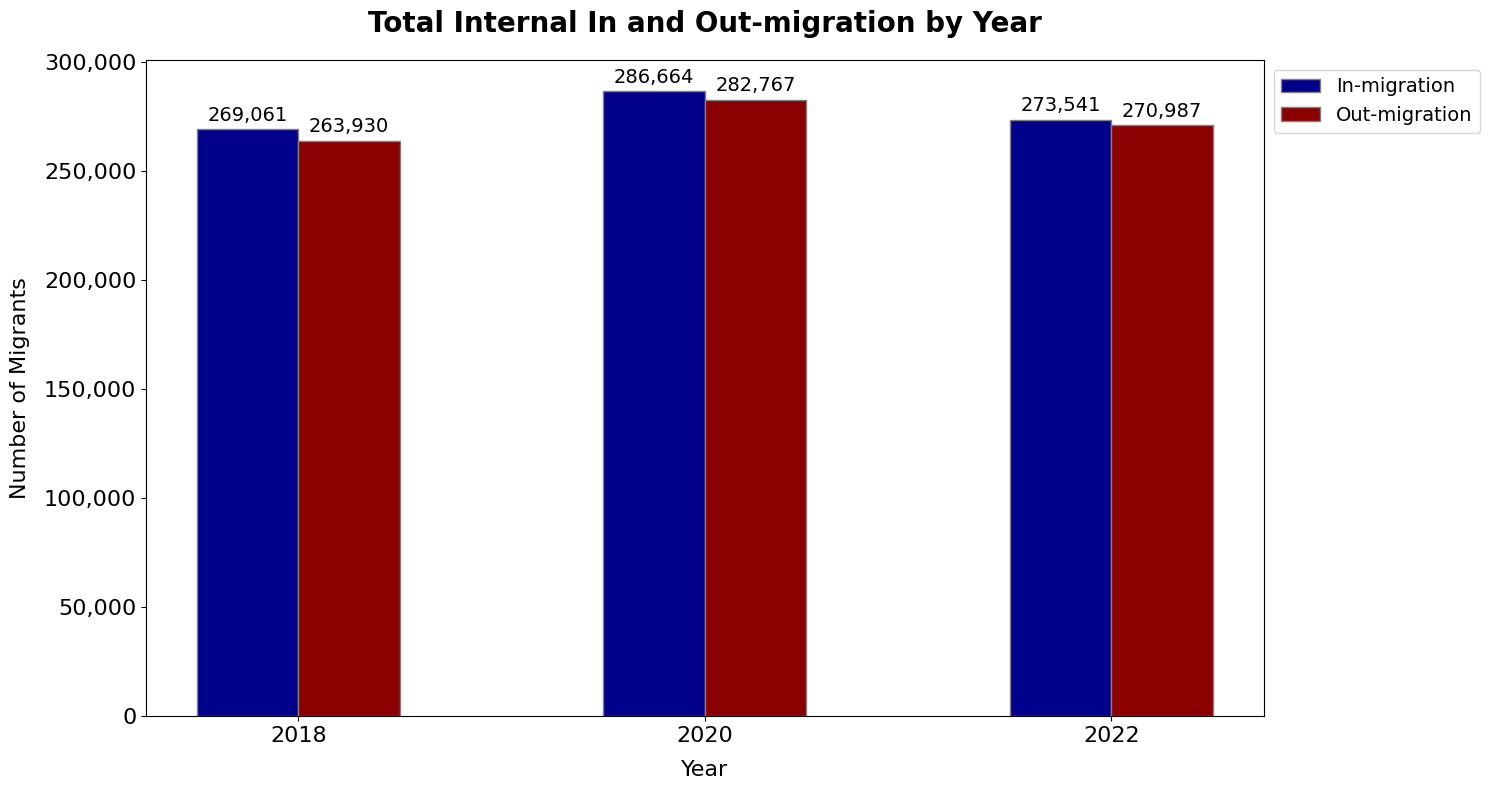

In [71]:
#Setting on or off for number at the top of the bars:
def add_values_on_bars(ax, turn_on_off):
    if turn_on_off == "on":
        for p in ax.patches:
            ax.annotate(format(p.get_height(), ',.0f'), 
                        (p.get_x() + p.get_width() / 2., p.get_height()), 
                        ha = 'center', 
                        va = 'center', 
                        xytext = (0, 10), 
                        textcoords = 'offset points',
                        fontsize=14)

# Group by Year, summing up the Inmig_int and Outmig_int
in_out_migration_by_year = in_out_migration_greater_region.groupby(['Year'])[['INMIG', 'OUTMIG']].sum().reset_index()

# Set the width of the bars
barWidth = 0.25

# Set position of bars on X axis
r1 = np.arange(len(in_out_migration_by_year))
r2 = [x + barWidth for x in r1]

fig, ax = plt.subplots(figsize=(15, 8))

# Make the plot
ax.bar(r1, in_out_migration_by_year['INMIG'], color='darkblue', width=barWidth, edgecolor='grey', label='In-migration')
ax.bar(r2, in_out_migration_by_year['OUTMIG'], color='darkred', width=barWidth, edgecolor='grey', label='Out-migration')

# Adding labels
ax.set_xlabel('Year', fontsize=16, labelpad=10)
ax.set_ylabel('Number of Migrants', fontsize=16, labelpad=10)
ax.set_title('Total Internal In and Out-migration by Year', fontsize=20, pad=20, weight='bold')

# Add xticks on the middle of the group bars
ax.set_xticks([r + barWidth/2 for r in range(len(in_out_migration_by_year))])

# Update x-axis ticks to show actual Year values
ax.set_xticklabels(in_out_migration_by_year['Year'])

# Create legend & Show graphic
ax.legend(fontsize=14, loc='upper left', bbox_to_anchor=(1, 1))
add_values_on_bars(ax, "on")
ax.yaxis.set_major_formatter(mtick.StrMethodFormatter('{x:,.0f}'))

# Increase the size of the y-axis and x-axis tick labels
ax.tick_params(axis='both', which='major', labelsize=16)

plt.tight_layout()
plt.savefig('data/total_population_migrations.png', bbox_inches='tight', dpi=300)

plt.show()

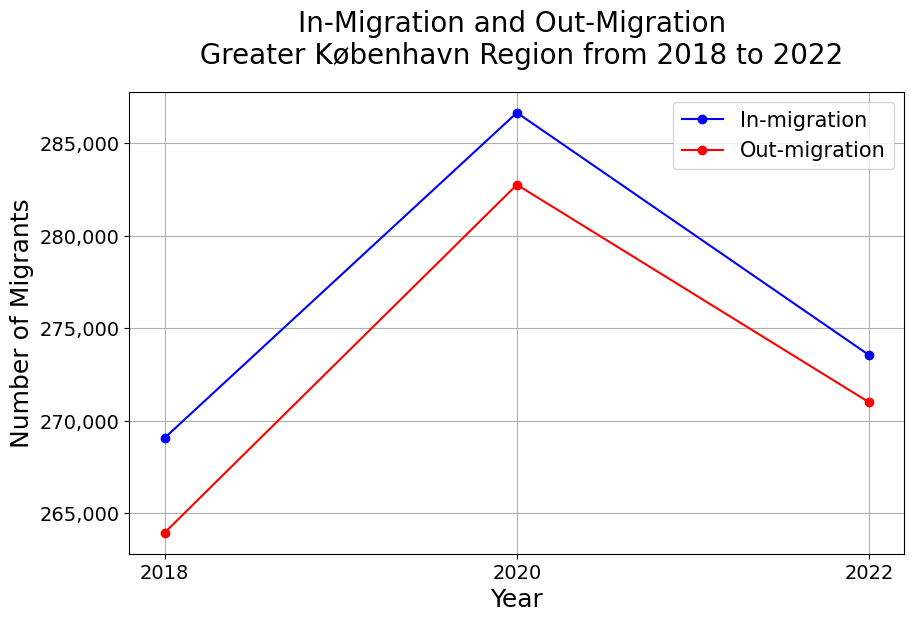

In [72]:
# Group by year and sum the in-migration and out-migration
yearly_migration = in_out_migration_greater_region.groupby('Year').agg({
    'INMIG': 'sum',
    'OUTMIG': 'sum'
}).reset_index()

# Create a line plot
plt.figure(figsize=(10, 6))

# Plotting the data
plt.plot(yearly_migration['Year'], yearly_migration['INMIG'], label='In-migration', marker='o', color='blue')
plt.plot(yearly_migration['Year'], yearly_migration['OUTMIG'], label='Out-migration', marker='o', color='red')

# Formatting the x-axis to remove ".0" by converting the 'Year' column to int
yearly_migration['Year'] = yearly_migration['Year'].astype(int)

# Creating the x-ticks based on the years
plt.xticks(yearly_migration['Year'].unique())

# Setting the y-axis with a thousands separator
plt.gca().get_yaxis().set_major_formatter(
    ticker.FuncFormatter(lambda x, p: format(int(x), ','))
)

# Setting labels and title with increased font sizes
plt.xlabel('Year', fontsize=18)
plt.ylabel('Number of Migrants', fontsize=18)
plt.title('In-Migration and Out-Migration \n Greater København Region from 2018 to 2022', fontsize=20, pad=20)
plt.legend(fontsize=15)

# Setting the size of the tick labels
plt.xticks(fontsize=14)  # Change the number to set the size of the x-axis tick labels
plt.yticks(fontsize=14)  # Change the number to set the size of the y-axis tick labels

# Save the figure
plt.savefig('data/total_migration_change.png', bbox_inches='tight', dpi=300)

plt.grid(True)
plt.show()

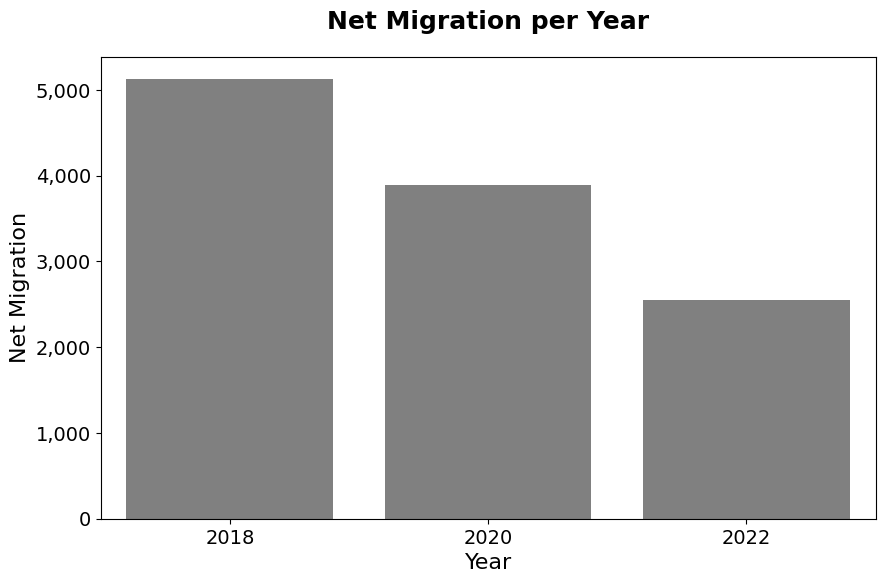

In [73]:
# Group data by year and calculate the sum of Net_Migration

# Calculate net migration
in_out_migration_greater_region['Net_Mig'] = in_out_migration_greater_region['INMIG'] - in_out_migration_greater_region['OUTMIG']

yearly_net_migration = in_out_migration_greater_region.groupby('Year')['Net_Mig'].sum().reset_index()

# Plotting
plt.figure(figsize=(10, 6))

sns.barplot(data=yearly_net_migration, x='Year', y='Net_Mig', color='gray')

plt.title('Net Migration per Year', fontsize=18, fontweight='bold', pad=20)
plt.xlabel('Year', fontsize=16)
plt.ylabel('Net Migration', fontsize=16)

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

# This will add a thousands separator to y-axis
plt.gca().get_yaxis().set_major_formatter(ticker.FuncFormatter(lambda x, p: format(int(x), ',')))

# Save the figure
plt.savefig('data/net_migration_per_year_gray.png', bbox_inches='tight', dpi=300)

# Display the plot
plt.show()

### Relative Numbers Graphs

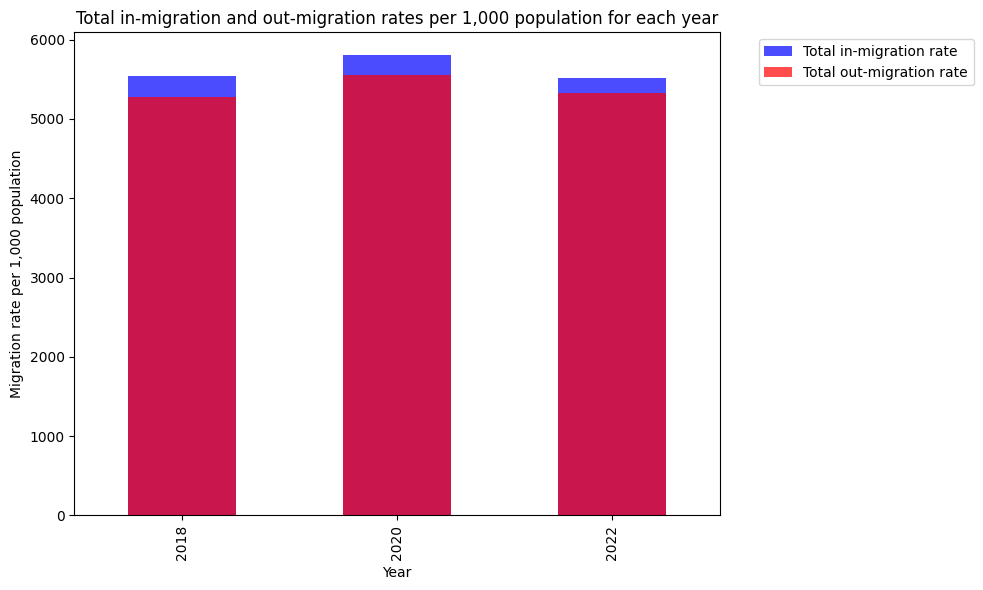

In [74]:
# Calculate the in-migration and out-migration rates
in_out_migration_greater_region['Inmig_rate'] = (in_out_migration_greater_region['INMIG'] / in_out_migration_greater_region['TOTALPOP']) * 1000
in_out_migration_greater_region['Outmig_rate'] = (in_out_migration_greater_region['OUTMIG'] / in_out_migration_greater_region['TOTALPOP']) * 1000

# Group by year and calculate the sum of in-migration and out-migration rates for each year
df_grouped = in_out_migration_greater_region.groupby('Year').agg({'Inmig_rate': 'sum', 'Outmig_rate': 'sum'})

# Plot the total in-migration and out-migration rates for each year
plt.figure(figsize=(10,6))

df_grouped['Inmig_rate'].plot(kind='bar', alpha=0.7, color='blue', label='Total in-migration rate')
df_grouped['Outmig_rate'].plot(kind='bar', alpha=0.7, color='red', label='Total out-migration rate')

plt.title('Total in-migration and out-migration rates per 1,000 population for each year')
plt.xlabel('Year')
plt.ylabel('Migration rate per 1,000 population')

# Place legend outside of the plot
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

# Adjust layout to fit legend
plt.tight_layout()

plt.show()

In [75]:
# Print the total in-migration and out-migration rates for each year
for year in df_grouped.index:
    print(f"For the year {year}:")
    print(f"Total in-migration rate: {df_grouped.loc[year, 'Inmig_rate']:.2f} per 1,000 population")
    print(f"Total out-migration rate: {df_grouped.loc[year, 'Outmig_rate']:.2f} per 1,000 population")
    print()

For the year 2018:
Total in-migration rate: 5541.27 per 1,000 population
Total out-migration rate: 5274.55 per 1,000 population

For the year 2020:
Total in-migration rate: 5802.46 per 1,000 population
Total out-migration rate: 5550.69 per 1,000 population

For the year 2022:
Total in-migration rate: 5522.85 per 1,000 population
Total out-migration rate: 5332.95 per 1,000 population



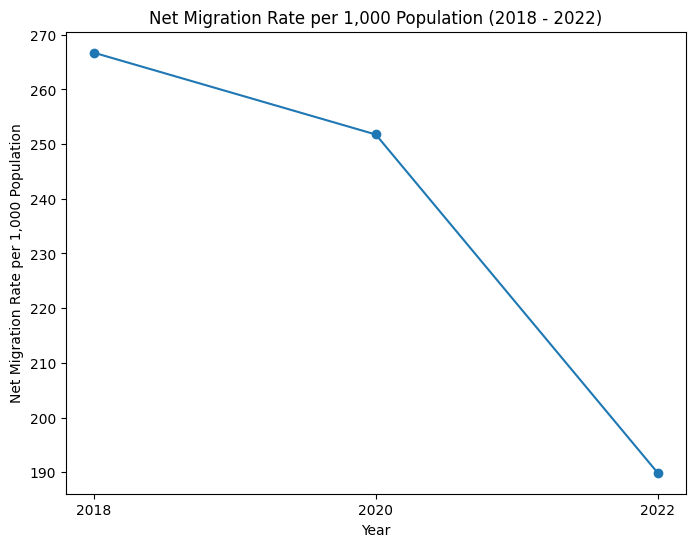

In [76]:
# Calculate net migration rate for each year
in_out_migration_greater_region['Net_Mig_Rate'] = (in_out_migration_greater_region['INMIG'] - 
                                                   in_out_migration_greater_region['OUTMIG']) / in_out_migration_greater_region['TOTALPOP'] * 1000

# Group data by year and calculate the sum of net migration rate for each year
net_migration_rate_per_year = in_out_migration_greater_region.groupby('Year')['Net_Mig_Rate'].sum()

# Plot the data
plt.figure(figsize=(8, 6))
net_migration_rate_per_year.plot(marker='o')

# Adding title and labels
plt.title('Net Migration Rate per 1,000 Population (2018 - 2022)')
plt.xlabel('Year')
plt.ylabel('Net Migration Rate per 1,000 Population')

# Set x-ticks to be years
plt.xticks(net_migration_rate_per_year.index.astype(int))

# Show the plot
plt.show()

## Age Groups Analysis

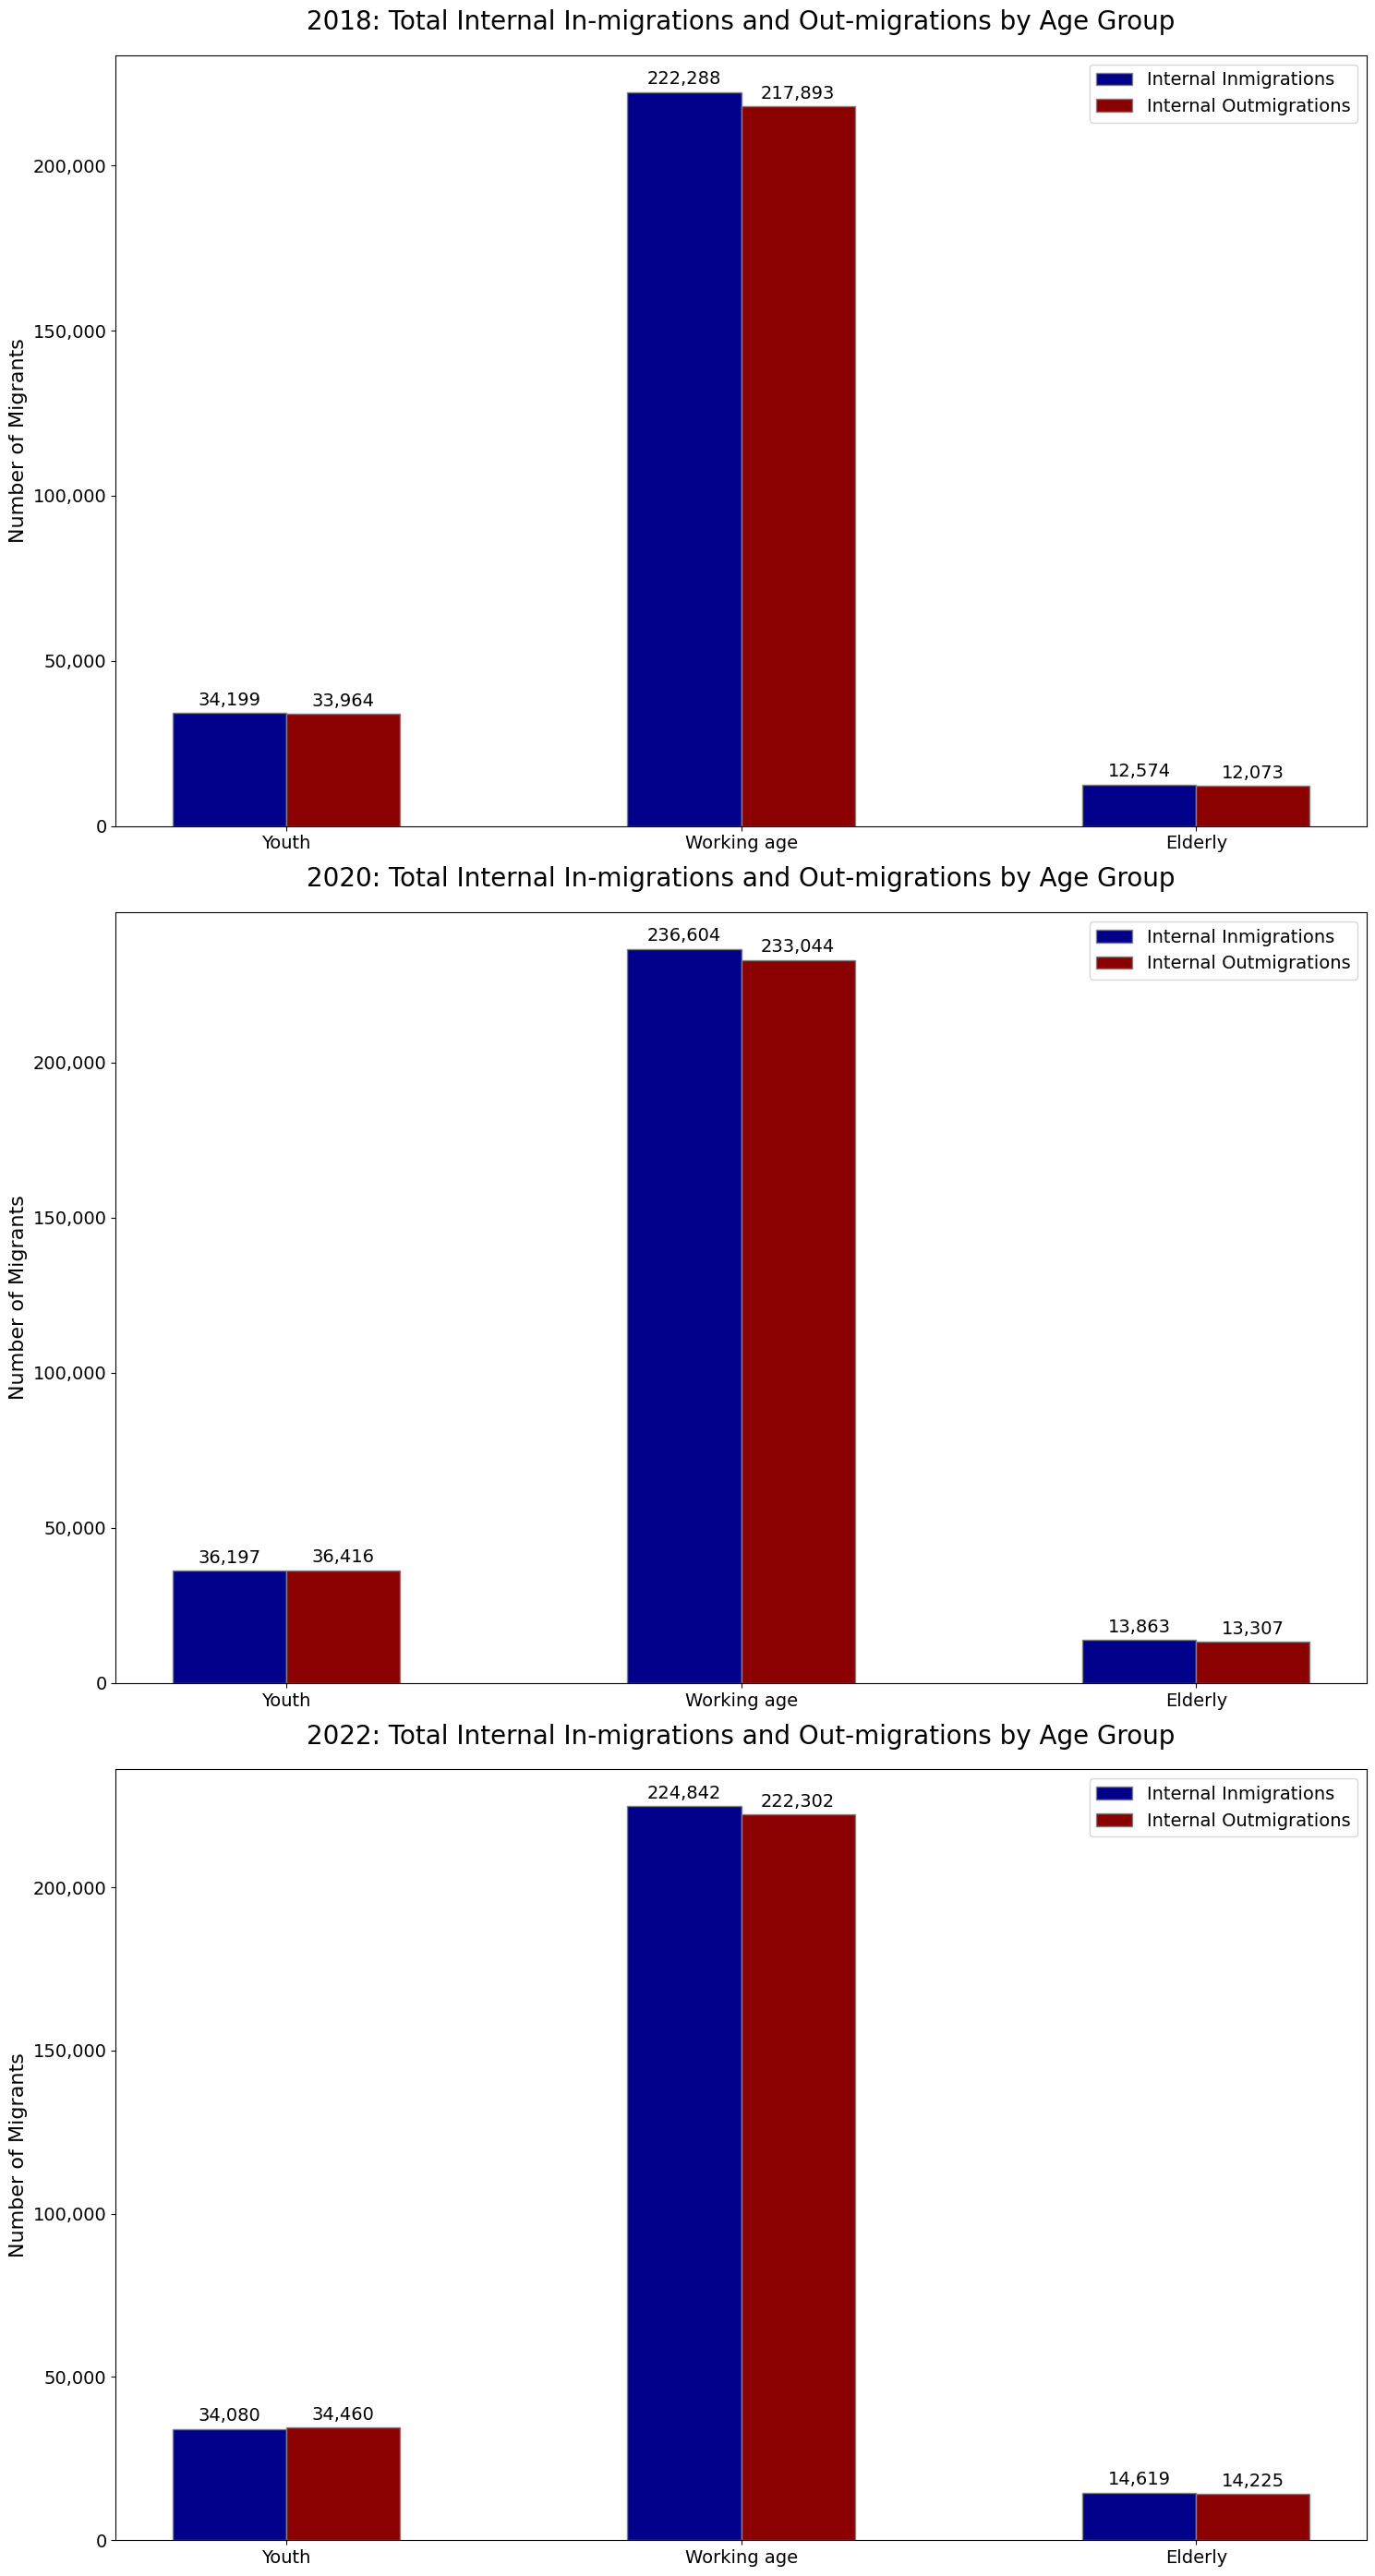

In [77]:
#AGE GROUPS IN and OUT migration per year graphs (Absolute Numbers)
#Function to display values at the top of the bars:
def add_values_on_bars(ax, turn_on_off):
    if turn_on_off == "on":
        for p in ax.patches:
            ax.annotate(format(p.get_height(), ',.0f'), 
                        (p.get_x() + p.get_width() / 2., p.get_height()), 
                        ha = 'center', 
                        va = 'center', 
                        xytext = (0, 10), 
                        textcoords = 'offset points',
                        fontsize=14)

# Filter dataframe for each year
df_gcphr_2018 = in_out_migration_greater_region[in_out_migration_greater_region['Year'] == 2018]
df_gcphr_2020 = in_out_migration_greater_region[in_out_migration_greater_region['Year'] == 2020]
df_gcphr_2022 = in_out_migration_greater_region[in_out_migration_greater_region['Year'] == 2022]

# Create a dictionary to store the grouped data for each year
grouped_data = {}

# Set order for Age Group
order_agegroup = ["Youth", "Working age", "Elderly"]

for df, year in zip([df_gcphr_2018, df_gcphr_2020, df_gcphr_2022], [2018, 2020, 2022]):
    inmigrations = df.groupby('Age_Group')['INMIG'].sum().reindex(order_agegroup)
    outmigrations = df.groupby('Age_Group')['OUTMIG'].sum().reindex(order_agegroup)
    grouped_data[year] = (inmigrations, outmigrations)

# Create subplots
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(15, 28))

# Set the width of the bars
barWidth = 0.25

# Plot data for each year
for ax, year in zip(axes, [2018, 2020, 2022]):
    inmigrations, outmigrations = grouped_data[year]

    # Set position of bars on X axis
    r1 = np.arange(len(inmigrations))
    r2 = [x + barWidth for x in r1]

    ax.bar(r1, inmigrations, color='darkblue', width=barWidth, edgecolor='grey', label='Internal Inmigrations')
    ax.bar(r2, outmigrations, color='darkred', width=barWidth, edgecolor='grey', label='Internal Outmigrations')

    ax.set_title(f'{year}: Total Internal In-migrations and Out-migrations by Age Group', fontsize=20, pad=20)
    ax.set_ylabel('Number of Migrants', fontsize=16)
    ax.set_xticks([r + barWidth/2 for r in range(len(inmigrations))])
    ax.set_xticklabels(inmigrations.index, fontsize=14)
    ax.legend(fontsize=14)
    add_values_on_bars(ax, "on")
    ax.yaxis.set_major_formatter(mtick.StrMethodFormatter('{x:,.0f}'))

    # Increase the size of the y-axis tick labels
    for label in ax.get_yticklabels():
        label.set_size(14)
# Save the figure
plt.savefig('data/in_out_mig_agegroup.png', bbox_inches='tight', dpi=300)

# Show the plot
plt.tight_layout()
plt.show()

<function matplotlib.pyplot.show(close=None, block=None)>

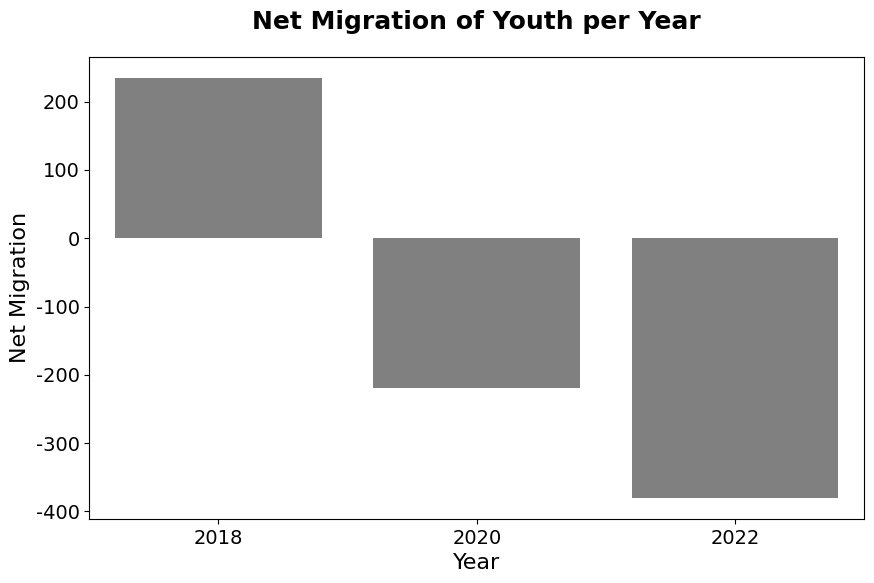

In [78]:
# Filter the data for the 'Age_Group' age group)
age_group_class = 'Youth'
youth_data = in_out_migration_greater_region[in_out_migration_greater_region['Age_Group'] == 'Youth']

# Group the filtered data by year and calculate the sum of Net_Migration
yearly_net_migration_youth = youth_data.groupby('Year')['Net_Mig'].sum().reset_index()

# Plotting
plt.figure(figsize=(10, 6))

sns.barplot(data=yearly_net_migration_youth, x='Year', y='Net_Mig', color='gray')

plt.title('Net Migration of Youth per Year', fontsize=18, fontweight='bold', pad=20)
plt.xlabel('Year', fontsize=16)
plt.ylabel('Net Migration', fontsize=16)

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

# This will add a thousands separator to y-axis
plt.gca().get_yaxis().set_major_formatter(ticker.FuncFormatter(lambda x, p: format(int(x), ',')))

# Save the figure
plt.savefig(f'data/net_migration_{age_group_class}.png', bbox_inches='tight', dpi=300)

# Display the plot
plt.show

In [79]:
# Calculate the percentage change
yearly_net_migration_youth['Pct_Change'] = yearly_net_migration_youth['Net_Mig'].pct_change() * 100
# Print the DataFrame
print(yearly_net_migration_youth)

   Year  Net_Mig  Pct_Change
0  2018      235         NaN
1  2020     -219 -193.191489
2  2022     -380   73.515982


<function matplotlib.pyplot.show(close=None, block=None)>

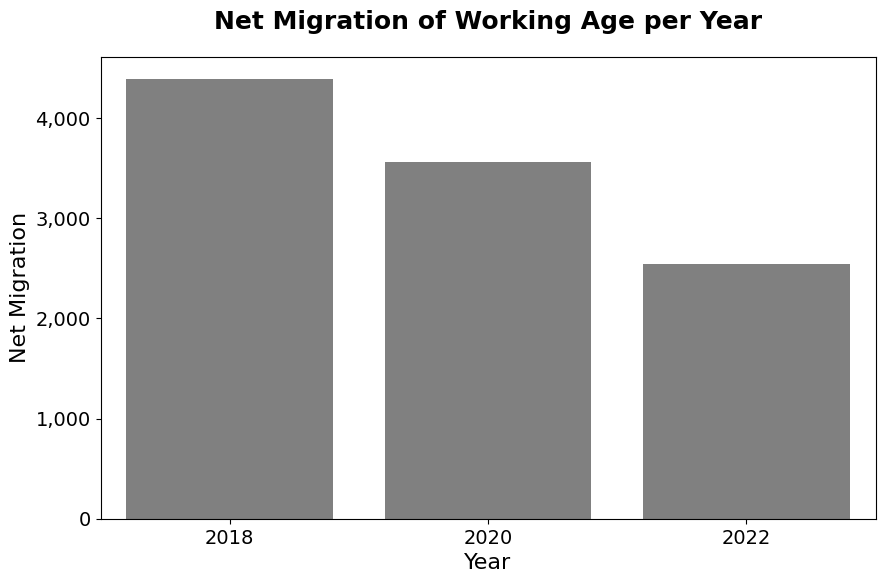

In [80]:
# Filter the data for the 'Age_Group' age group)
age_group_class = 'Working Age'
youth_data = in_out_migration_greater_region[in_out_migration_greater_region['Age_Group'] == 'Working age']

# Group the filtered data by year and calculate the sum of Net_Migration
yearly_net_migration_youth = youth_data.groupby('Year')['Net_Mig'].sum().reset_index()

# Plotting
plt.figure(figsize=(10, 6))

sns.barplot(data=yearly_net_migration_youth, x='Year', y='Net_Mig', color='gray')

plt.title(f'Net Migration of {age_group_class} per Year', fontsize=18, fontweight='bold', pad=20)
plt.xlabel('Year', fontsize=16)
plt.ylabel('Net Migration', fontsize=16)

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

# This will add a thousands separator to y-axis
plt.gca().get_yaxis().set_major_formatter(ticker.FuncFormatter(lambda x, p: format(int(x), ',')))

# Save the figure
plt.savefig(f'data/net_migration_{age_group_class}.png', bbox_inches='tight', dpi=300)

# Display the plot
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

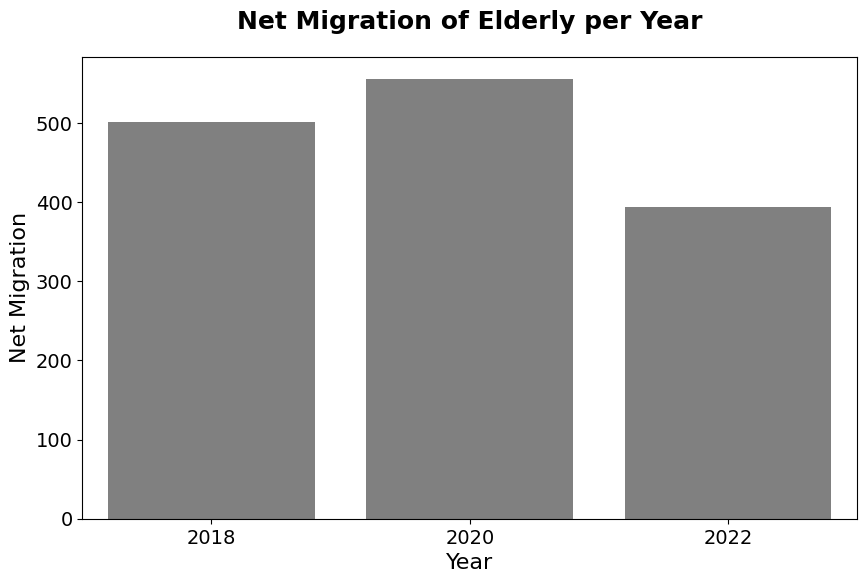

In [81]:
# Filter the data for the 'Age_Group' age group)
age_group_class = 'Elderly'
youth_data = in_out_migration_greater_region[in_out_migration_greater_region['Age_Group'] == 'Elderly']

# Group the filtered data by year and calculate the sum of Net_Migration
yearly_net_migration_youth = youth_data.groupby('Year')['Net_Mig'].sum().reset_index()

# Plotting
plt.figure(figsize=(10, 6))

sns.barplot(data=yearly_net_migration_youth, x='Year', y='Net_Mig', color='gray')

plt.title(f'Net Migration of {age_group_class} per Year', fontsize=18, fontweight='bold', pad=20)
plt.xlabel('Year', fontsize=16)
plt.ylabel('Net Migration', fontsize=16)

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

# This will add a thousands separator to y-axis
plt.gca().get_yaxis().set_major_formatter(ticker.FuncFormatter(lambda x, p: format(int(x), ',')))

# Save the figure
plt.savefig(f'data/net_migration_{age_group_class}.png', bbox_inches='tight', dpi=300)

# Display the plot
plt.show

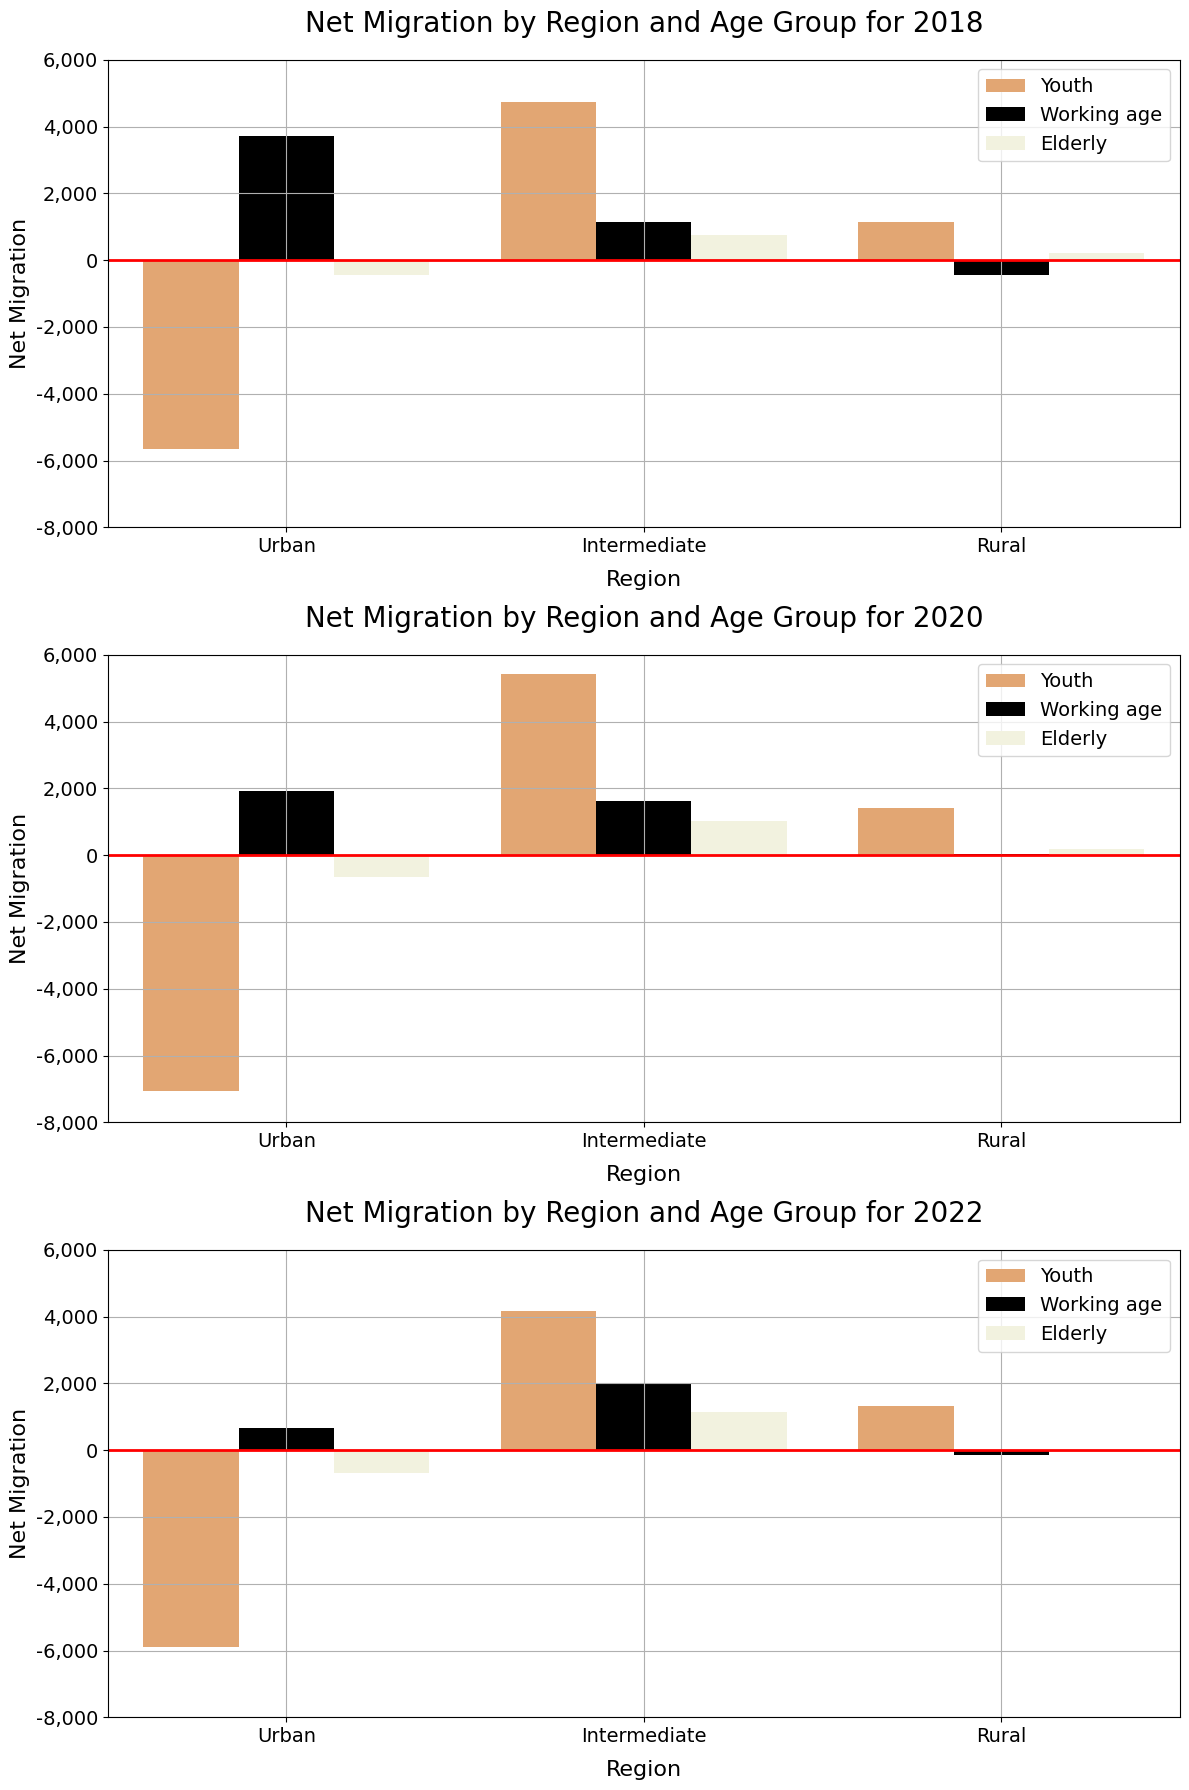

In [82]:
#Grouping the data by year, region and age group:
total_df = in_out_migration_greater_region.groupby(['Year', 'DGURBA', 'Age_Group']).agg({
    'INMIG': 'sum',
    'OUTMIG': 'sum'
}).reset_index()

# Calculate net migration
total_df['Net_Mig'] = total_df['INMIG'] - total_df['OUTMIG']

# Define color palette for Urban, Intermediate, and Rural
palette = {"Elderly": "beige", "Working age": "black", "Youth": "sandybrown"}

# Define order for Age Group and DGURBA
order_agegroup = ["Youth", "Working age", "Elderly"]
order_dgurba = ["Urban", "Intermediate", "Rural"] # <- New line

# Create a figure with 3 subplots (one for each year)
fig, axs = plt.subplots(3, 1, figsize=(12, 18))

years = [2018, 2020, 2022]

for i, year in enumerate(years):
    # Filter data for the specific year
    year_data = total_df[total_df['Year'] == year] #

    # Create a barplot with 'DGURBA' and 'Net_Mig' in the y-axis
    sns.barplot(data=year_data, x='DGURBA', y='Net_Mig', hue='Age_Group', hue_order=order_agegroup, order=order_dgurba, ax=axs[i], palette=palette) # <- Added order parameter

    axs[i].set_title(f'Net Migration by Region and Age Group for {year}', fontsize=20, pad=20)
    axs[i].set_xlabel('Region', fontsize=16, labelpad=10)  # added labelpad for space
    axs[i].set_ylabel('Net Migration', fontsize=16)
    axs[i].legend(fontsize=14)
    axs[i].get_yaxis().set_major_formatter(ticker.FuncFormatter(lambda x, p: format(int(x), ',')))

    # Add grid
    axs[i].grid(True)

    # Set y-axis limit
    axs[i].set_ylim(-8000, 6000)

    # Add horizontal line at y=0
    axs[i].axhline(0, color='red', linewidth=2)

    # Setting the size of the tick labels
    axs[i].tick_params(axis='x', labelsize=14)
    axs[i].tick_params(axis='y', labelsize=14)

# Adjust the space between subplots
plt.subplots_adjust(hspace = 0.5)

# Save the figure
plt.savefig('data/net_migration_by_agegroup_region.png', bbox_inches='tight', dpi=300)

plt.tight_layout()
plt.show()

## Region Analysis

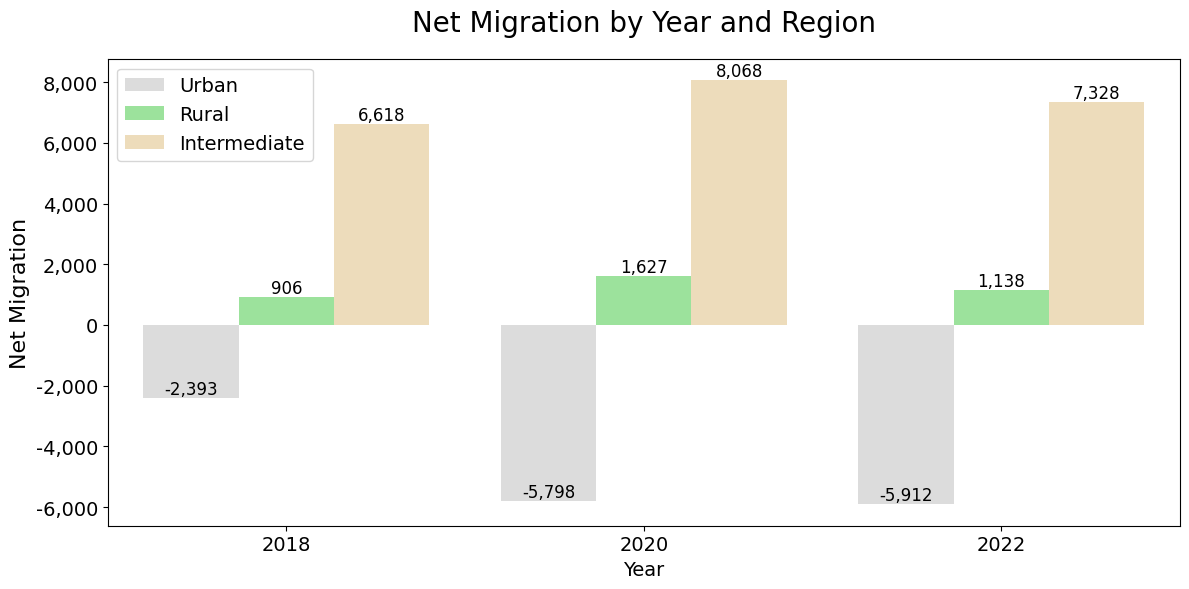

In [83]:
#Grouping the data by year, region and age group:
total_df = in_out_migration_greater_region.groupby(['Year', 'DGURBA']).agg({
    'INMIG': 'sum',
    'OUTMIG': 'sum'
}).reset_index()

# Calculate net migration
total_df['Net_Mig'] = total_df['INMIG'] - total_df['OUTMIG']

# Create subplots
fig, ax = plt.subplots(figsize=(12, 6))

# Define color palette for Urban, Intermediate, and Rural
palette = {"Urban": "gainsboro", "Intermediate": "wheat", "Rural": "lightgreen"}

# Define order for DGURBA
order_dgurba = ["Urban", "Rural", "Intermediate"]

# Net migration barplot
sns.barplot(data=total_df, x='Year', y='Net_Mig', hue='DGURBA', hue_order=order_dgurba, ax=ax, palette=palette)
ax.set_title('Net Migration by Year and Region', fontsize=20, pad=20)
ax.set_ylabel('Net Migration', fontsize=16)
ax.set_xlabel('Year', fontsize=14)
ax.legend(fontsize=14)
ax.get_yaxis().set_major_formatter(ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
ax.set_xticklabels(total_df['Year'].unique(), fontsize=16)

# Loop over the bars, and use the bar height (value) as the label
for p in ax.patches:
    ax.text(p.get_x() + p.get_width() / 2., p.get_height(), '{:,}'.format(int(p.get_height())), 
            fontsize=12, color='black', ha='center', va='bottom')

    # Setting the size of the tick labels
plt.xticks(fontsize=14)  # Change the number to set the size of the x-axis tick labels
plt.yticks(fontsize=14)  # Change the number to set the size of the y-axis tick labels

# Save the figure
plt.savefig('data/total_migration_by_region.png', bbox_inches='tight', dpi=300)
    
plt.tight_layout()
plt.show()

In [84]:
# Delete a folder and its contents recursively
#!rm -r /content/data